# Analysis of Travel Dataset: Guide to India's Must See Places

In [2]:
#Import libarys
import pandas as pd
import math
import pingouin as pg
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy as sp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.express as px
import plotly
import plotly.graph_objects as go
from plotly.graph_objs import Scatter, Figure, Histogram, Layout, Bar
plotly.offline.init_notebook_mode(connected = True)
from plotly.subplots import make_subplots

This dataset was downloaded from [Kaggle](https://www.kaggle.com/datasets/saketk511/travel-dataset-guide-to-indias-must-see-places).

The data is loaded into the noteboook, and the head and shape is displayed for initial inspection.

Through the process of the following inspection, it is found that the dataset is completely without NaN values.
The na_filter is set to False to avoid filtering string of 'None' in the variable that describes what day an attraction is not open.

In [2147]:
#File renamed to 'data.csv' and saved in current working directory
with open('data.csv') as x:
    ncols = len(x.readline().split(','))

df_raw = pd.read_csv('data.csv', usecols=range(1,ncols), na_filter = False)

In [2149]:
#Make a copy of the dataset to avoid the need to re-import
df = df_raw.copy()

In [2451]:
#display dataframe head for initial inspection
df.head()

zone  state   city                  name          type  year  time  \
0  Northern  Delhi  Delhi            India Gate  War Memorial  1921   0.5   
1  Northern  Delhi  Delhi        Humayun's Tomb          Tomb  1572   2.0   
2  Northern  Delhi  Delhi     Akshardham Temple        Temple  2005   5.0   
3  Northern  Delhi  Delhi  Waste to Wonder Park    Theme Park  2019   2.0   
4  Northern  Delhi  Delhi         Jantar Mantar   Observatory  1724   2.0   

   rating  fee airport  ... reviews      visit camera_num  airport_num  \
0     4.6    0     Yes  ...    2.60    Evening          1            1   
1     4.5   30     Yes  ...    0.40  Afternoon          1            1   
2     4.6   60     Yes  ...    0.40  Afternoon          0            1   
3     4.1   50     Yes  ...    0.27    Evening          1            1   
4     4.2   15     Yes  ...    0.31    Morning          1            1   

  year_num  cost_ratio  rating_norm   fee_log  reviews_log  cost_ratio_log  
0   1921.0         0.0     0.415259  0.000000     1.280934        0.000000  
1   1572.0        15.0     0.050504  3.433987     0.336472        2.772589  
2   2005.0        12.0     0.415259  4.110874     0.336472        2.564949  
3   2019.0        25.0    -1.408513  3.931826     0.239017        3.258097  
4   1724.0         7.5    -1.043759  2.772589     0.270027        2.140066  

[5 rows x 23 columns]

In [2155]:
# Dataset shape
print(df.shape)
 
rows, columns = df.shape
print(f"The dataset comprises {rows} properties described across {columns} attributes.")

(325, 15)
The dataset comprises 325 properties described across 15 attributes.




Data types are analysed to shape analysis approach.

In [2157]:
#Determine the data type for each feature
data_types = df.dtypes
 
# View a few datatypes from the dataset
print(data_types)

Zone                                 object
State                                object
City                                 object
Name                                 object
Type                                 object
Establishment Year                   object
time needed to visit in hrs         float64
Google review rating                float64
Entrance Fee in INR                   int64
Airport with 50km Radius             object
Weekly Off                           object
Significance                         object
DSLR Allowed                         object
Number of google review in lakhs    float64
Best Time to visit                   object
dtype: object


Note that 'Establishment Year' is object, which is string type. This will need to be coverted to numerical for analysis.

In [2159]:
# Tally the total by data type
type_counts = data_types.value_counts()
 
print(type_counts)

object     11
float64     3
int64       1
Name: count, dtype: int64


Visualizing the Missing Values

In [2161]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

# Combining the counts and percentages into a DataFrame for better visualization
missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})

# Sorting the DataFrame by the percentage of missing values in descending order
missing_info = missing_info.sort_values(by='Percentage', ascending=False)

# Display columns with missing values
print(missing_info[missing_info['Missing Values'] > 0])

Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


The dataset has no missing values. 

In [2129]:
# Check the structure of the dataset
print("\nStructure of the dataset:")
print(df.info())


Structure of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Zone                              325 non-null    object 
 1   State                             325 non-null    object 
 2   City                              325 non-null    object 
 3   Name                              325 non-null    object 
 4   Type                              325 non-null    object 
 5   Establishment Year                325 non-null    object 
 6   time needed to visit in hrs       325 non-null    float64
 7   Google review rating              325 non-null    float64
 8   Entrance Fee in INR               325 non-null    int64  
 9   Airport with 50km Radius          325 non-null    object 
 10  Weekly Off                        325 non-null    object 
 11  Significance                      325 non-nu

Modify the dataframe to simplify and improve the data analysis approach.

In [2497]:
# Convert column names to lowercase
df.columns = df.columns.str.lower()

#rename columns to make them easier to work with
df = df.rename(columns = {'establishment year':'year', 'time needed to visit in hrs':'time', 'google review rating':'rating',
                         'entrance fee in inr':'fee', 'airport with 50km radius':'airport', 'weekly off':'off',
                         'dslr allowed':'camera', 'number of google review in lakhs':'reviews', 'best time to visit':'visit'})

# convert Binary variables to numerical
df['camera_num'] = df['camera'].astype('category').cat.codes

df['airport_num'] = df['airport'].astype('category').cat.codes

# Convert 'Establishment Year' to numeric based on conditions
df['year_num'] = df['year'].apply(
    lambda x: int(re.findall('[0-9-]+', x)[0]) if re.findall('[0-9-]+', x) != [] else np.nan).apply(
    lambda x: x * 100 if abs(x) < 100 else x)

# Clean visit variable category types
df['visit'] = df['visit'].str.strip().replace('All','Anytime').astype('category')

Additional numerical variables are created based on the existing variables.

'ratings' is normalized and log-scale columns are created for skewed variables.

In [2499]:
#Create column for ratio of fee to time ("Value")
df['cost_ratio'] = df['fee'] / df['time']

#Normalize ratings column
scaler = StandardScaler()
df['rating_norm'] = scaler.fit_transform(df[['rating']])

#log scale skewed variables
df['fee_log'] = np.log1p(df['fee'])

df['reviews_log'] = np.log1p(df['reviews'])

df['cost_ratio_log'] = np.log1p(df['cost_ratio'])

Sanity check on descriptive statistics

In [2170]:
# Descriptive statistics for numerical columns
print(df.describe())

             time      rating          fee     reviews  camera_num  \
count  325.000000  325.000000   325.000000  325.000000  325.000000   
mean     1.807692    4.486154   115.809231    0.408438    0.815385   
std      0.971398    0.274580   530.859785    0.646668    0.388584   
min      0.500000    1.400000     0.000000    0.010000    0.000000   
25%      1.000000    4.400000     0.000000    0.059000    1.000000   
50%      1.500000    4.500000     0.000000    0.170000    1.000000   
75%      2.000000    4.600000    40.000000    0.500000    1.000000   
max      7.000000    4.900000  7500.000000    7.400000    1.000000   

       airport_num     year_num   cost_ratio   rating_norm     fee_log  \
count   325.000000   213.000000   325.000000  3.250000e+02  325.000000   
mean      0.698462  1583.042254    43.621720 -9.073084e-16    1.834637   
std       0.459634   689.989850   185.167754  1.001542e+00    2.291259   
min       0.000000 -3500.000000     0.000000 -1.125688e+01    0.000000   

Proceeding with univariate analysis

In [2225]:
def univariate(x, df=df, outliers = 'yes'):
    """
    Display univariate information for numerical variables.
    
    Parameters
    ----------
    x : string
        The name of the numerical variable for analyis
    df : dataframe, optional
        The dataframe to analyze, default value = df
    outliers : string, optional
        'yes' to display outliers, 'no' to filter them, default value = 'yes'
    
    Returns
    -------
    Dataframe sorted by x column, largest values
    
    Dataframe sorted by x column, smallest values
    
    histogram of x with boxplot above
    
    """
    #display dataframe sorted by x column, largest values
    display(df.sort_values(x, ascending = False).head())

    #display dataframe sorted by x column, smallest values. If all values are 0, do not display
    if df.sort_values(x, ascending = True).head()[x].sum() > 0:
        display(df.sort_values(x, ascending = True).head())

    #filter outliers if enabled
    if outliers == 'no':
        df = df.loc[df[[x]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #display histogram of x variable
    fig = px.histogram(df, x=x, title = 'Histogram of ' + x, nbins = int(len(df) ** (1 / 2)), marginal = 'box', hover_name = 'name')
    fig.show()

zone              state       city                     name  \
78    Western            Gujarat  Ahmedabad             Science City   
200  Northern  Jammu and Kashmir   Anantnag            Amarnath Cave   
110  Southern             Kerala      Kochi  Wonderla Amusement Park   
15   Northern              Delhi      Delhi  National Science Centre   
26    Western         Maharastra   Lonavala                 Imagicaa   

               type     year  time  rating   fee airport  ... reviews  \
78          Science     2002   7.0     4.4   500     Yes  ...    0.11   
200          Temple  Unknown   6.0     4.5     0      No  ...    0.11   
110  Amusement Park     2016   5.5     4.6   750     Yes  ...    0.41   
15          Science     1992   5.0     4.4    70     Yes  ...    0.23   
26   Amusement Park     2013   5.0     1.4  1149      No  ...    0.95   

       visit camera_num  airport_num year_num  cost_ratio  rating_norm  \
78   Anytime          1            1   2002.0   71.428571    -0.314250   
200  Anytime          1            0      NaN    0.000000     0.050504   
110  Anytime          1            1   2016.0  136.363636     0.415259   
15   Anytime          1            1   1992.0   14.000000    -0.314250   
26   Anytime          1            0   2013.0  229.800000   -11.256880   

      fee_log  reviews_log  cost_ratio_log  
78   6.216606     0.104360        4.282601  
200  0.000000     0.104360        0.000000  
110  6.621406     0.343590        4.922632  
15   4.262680     0.207014        2.708050  
26   7.047517     0.667829        5.441552  

[5 rows x 23 columns]

zone        state     city                name          type  \
0    Northern        Delhi    Delhi          India Gate  War Memorial   
220   Eastern  West Bengal   Bolpur  Kankalitala Temple        Temple   
221   Eastern  West Bengal  Hooghly  Hangseswari Temple        Temple   
43    Eastern  West Bengal  Kolkata       Howrah Bridge        Bridge   
208  Northern       Ladakh      Leh       Magnetic Hill  Gravity Hill   

        year  time  rating  fee airport  ... reviews    visit camera_num  \
0       1921   0.5     4.6    0     Yes  ...   2.600  Evening          1   
220  Unknown   0.5     4.7    0     Yes  ...   0.045  Anytime          0   
221     1814   0.5     4.6    0     Yes  ...   0.070  Anytime          0   
43      1943   0.5     4.6    0     Yes  ...   1.200  Anytime          0   
208  Unknown   0.5     3.7    0     Yes  ...   0.100  Anytime          1   

     airport_num year_num  cost_ratio  rating_norm  fee_log  reviews_log  \
0              1   1921.0         0.0     0.415259      0.0     1.280934   
220            1      NaN         0.0     0.780013      0.0     0.044017   
221            1   1814.0         0.0     0.415259      0.0     0.067659   
43             1   1943.0         0.0     0.415259      0.0     0.788457   
208            1      NaN         0.0    -2.867530      0.0     0.095310   

     cost_ratio_log  
0               0.0  
220             0.0  
221             0.0  
43              0.0  
208             0.0  

[5 rows x 23 columns]

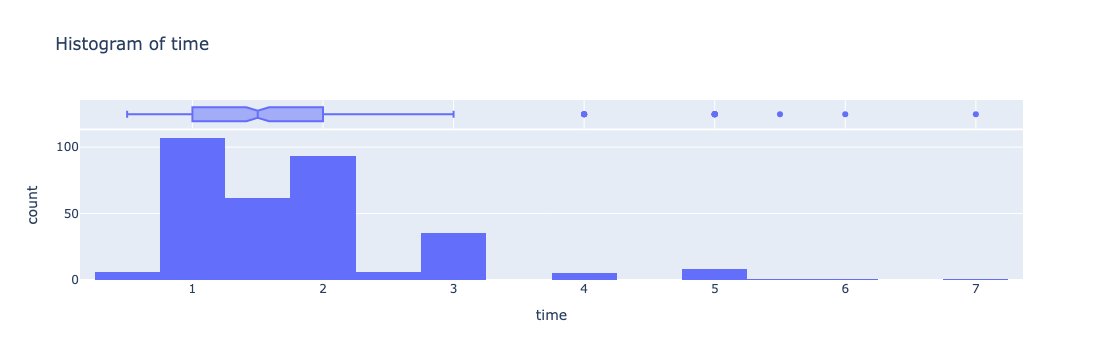

In [2227]:
univariate('time', outliers = 'yes')

zone    state           city                             name  \
196  Northern   Ladakh            Leh                      Pangong Tso   
72    Western  Gujarat  Rann of Kutch                       Rann Utsav   
92   Northern   Punjab       Amritsar  Golden Temple (Harmandir Sahib)   
94   Northern   Punjab       Amritsar                     Wagah Border   
207  Northern   Ladakh           Dras                Dras War Memorial   

                type     year  time  rating   fee airport  ... reviews  \
196             Lake  Unknown   2.0     4.9    20     Yes  ...   0.150   
72          Cultural  Unknown   3.0     4.9  7500     Yes  ...   0.100   
92    Religious Site     1604   1.5     4.9     0     Yes  ...   1.900   
94   Border Crossing     1950   2.0     4.8     0     Yes  ...   0.170   
207     War Memorial  Unknown   1.0     4.8     0      No  ...   0.012   

       visit camera_num  airport_num year_num  cost_ratio  rating_norm  \
196  Morning          1            1      NaN        10.0     1.509522   
72   Evening          1            1      NaN      2500.0     1.509522   
92   Anytime          1            1   1604.0         0.0     1.509522   
94   Evening          1            1   1950.0         0.0     1.144767   
207  Anytime          1            0      NaN         0.0     1.144767   

      fee_log  reviews_log  cost_ratio_log  
196  3.044522     0.139762        2.397895  
72   8.922792     0.095310        7.824446  
92   0.000000     1.064711        0.000000  
94   0.000000     0.157004        0.000000  
207  0.000000     0.011929        0.000000  

[5 rows x 23 columns]

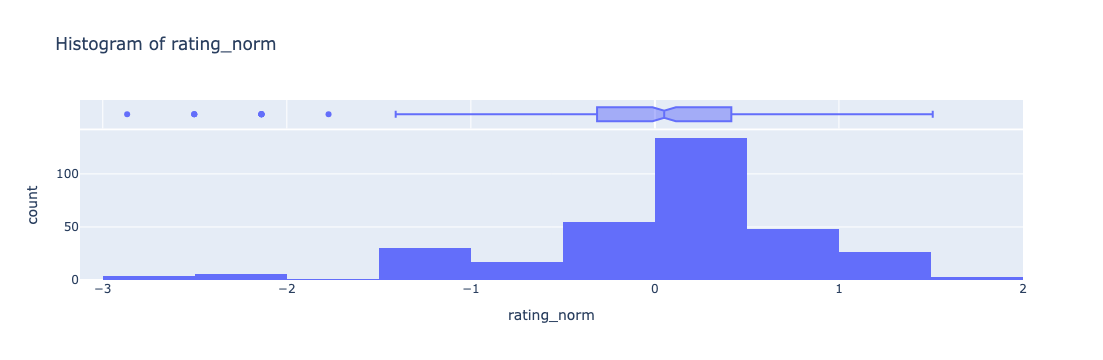

In [2346]:
univariate('rating_norm', outliers = 'no')

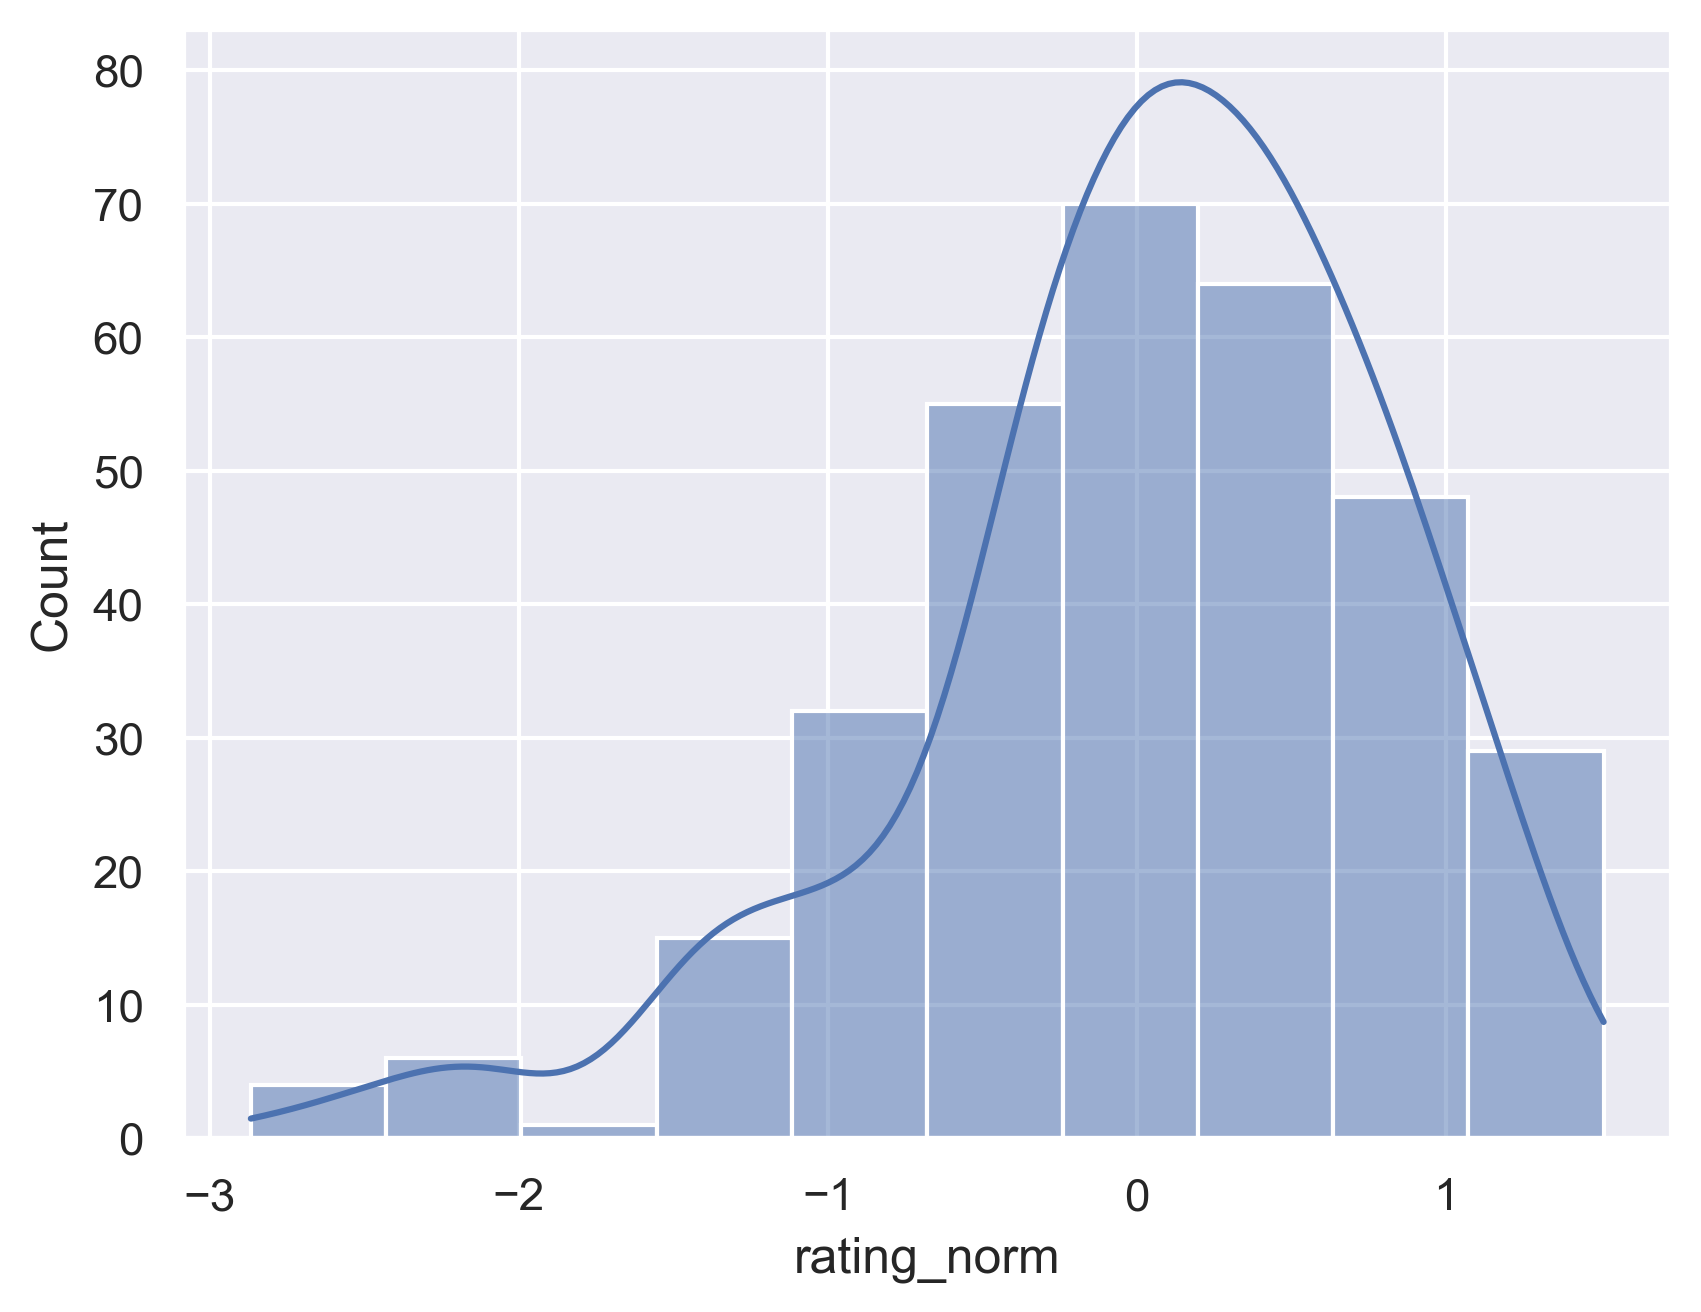

In [2622]:
sns.set_theme(style="darkgrid")
temp_df = df.loc[df[['rating_norm']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating_norm", bins=10, kde=True)#, hue = 'camera')
plt.show()

In [2644]:
df[['significance']].filter(lambda x: if x == 

significance
0       Historical
1       Historical
2        Religious
3    Environmental
4       Scientific
..             ...
320      Religious
321     Historical
322       Cultural
323     Historical
324     Historical

[325 rows x 1 columns]

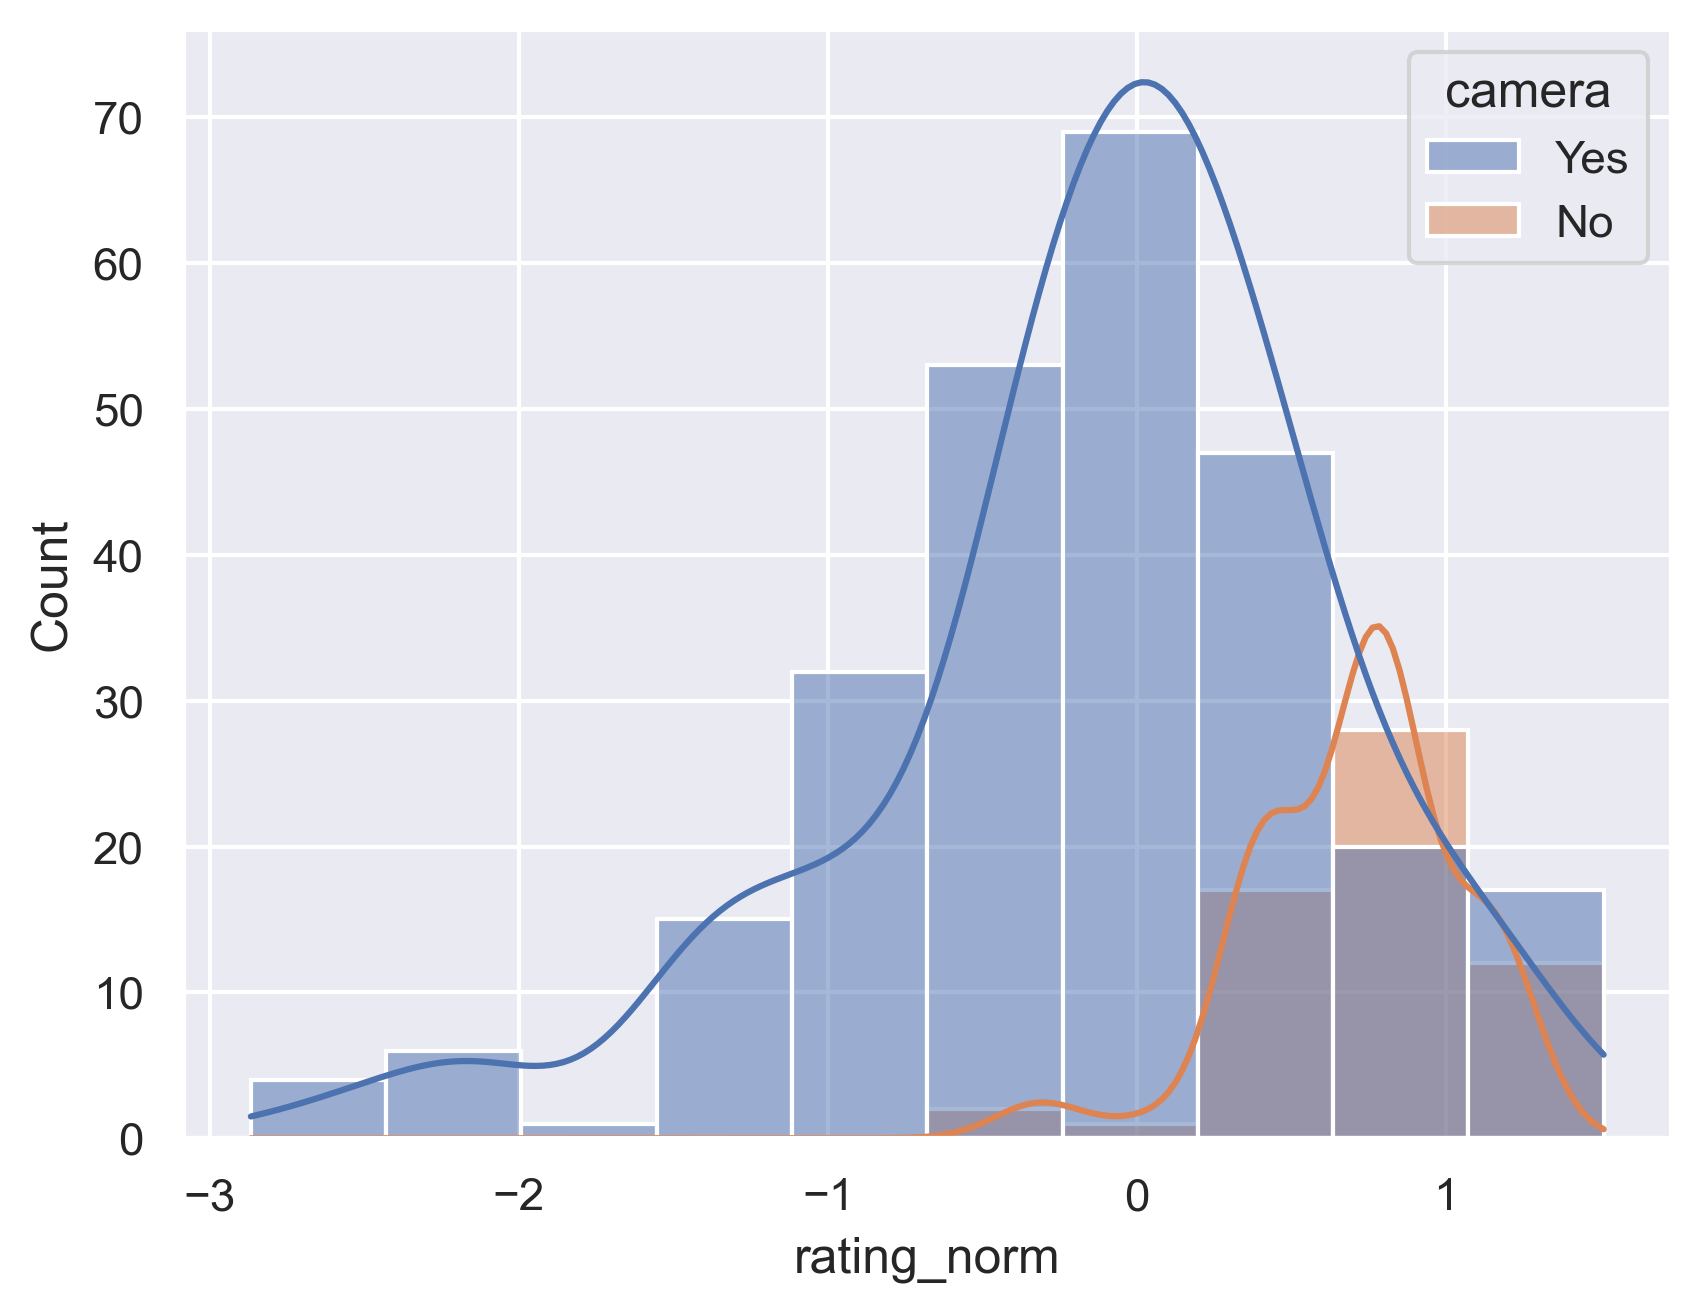

In [2640]:
sns.set_theme(style="darkgrid")
temp_df = df.loc[df[['rating_norm']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating_norm", bins=10, kde=True, hue = 'camera')
plt.show()

zone             state           city                         name  \
72    Western           Gujarat  Rann of Kutch                   Rann Utsav   
68    Western           Gujarat       Junagadh            Gir National Park   
161  Northern  Himachal Pradesh    Bir Billing             Paragliding Site   
47    Eastern       West Bengal        Kolkata                 Eden Gardens   
315   Central     Uttar Pradesh  Greater Noida  Buddh International Circuit   

                type     year  time  rating   fee airport  ... reviews  \
72          Cultural  Unknown   3.0     4.9  7500     Yes  ...    0.10   
68     National Park     1965   3.0     4.5  3500      No  ...    0.08   
161  Adventure Sport     2005   2.0     4.8  2500      No  ...    0.01   
47    Cricket Ground     1864   3.0     4.1  2500     Yes  ...    0.10   
315       Race Track     2011   2.0     4.6  1500     Yes  ...    7.40   

       visit camera_num  airport_num year_num   cost_ratio  rating_norm  \
72   Evening          1            1      NaN  2500.000000     1.509522   
68   Morning          1            0   1965.0  1166.666667     0.050504   
161  Anytime          1            0   2005.0  1250.000000     1.144767   
47   Anytime          1            1   1864.0   833.333333    -1.408513   
315  Anytime          1            1   2011.0   750.000000     0.415259   

      fee_log  reviews_log  cost_ratio_log  
72   8.922792     0.095310        7.824446  
68   8.160804     0.076961        7.062763  
161  7.824446     0.009950        7.131699  
47   7.824446     0.095310        6.726633  
315  7.313887     2.128232        6.621406  

[5 rows x 23 columns]

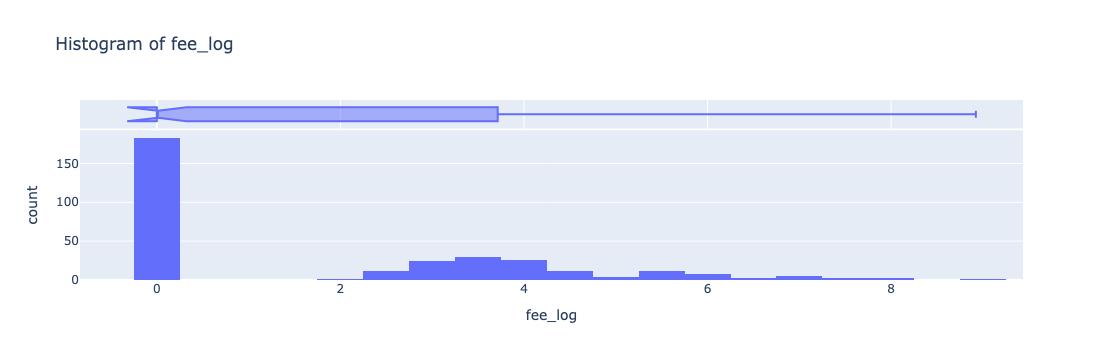

In [819]:
univariate('fee_log', outliers = 'yes')

zone          state           city                         name  \
315   Central  Uttar Pradesh  Greater Noida  Buddh International Circuit   
17    Western     Maharastra         Mumbai             Gateway of India   
0    Northern          Delhi          Delhi                   India Gate   
111  Southern      Karnataka         Mysore                Mysore Palace   
181   Central  Uttar Pradesh           Agra                    Taj Mahal   

             type  year  time  rating   fee airport  ... reviews    visit  \
315    Race Track  2011   2.0     4.6  1500     Yes  ...    7.40  Anytime   
17       Monument  1924   1.0     4.6     0     Yes  ...    3.60  Anytime   
0    War Memorial  1921   0.5     4.6     0     Yes  ...    2.60  Evening   
111        Palace  1912   2.0     4.6    50     Yes  ...    2.50  Anytime   
181     Mausoleum  1632   2.0     4.6    50     Yes  ...    2.25  Morning   

    camera_num  airport_num year_num  cost_ratio  rating_norm   fee_log  \
315          1            1   2011.0       750.0     0.415259  7.313887   
17           1            1   1924.0         0.0     0.415259  0.000000   
0            1            1   1921.0         0.0     0.415259  0.000000   
111          1            1   1912.0        25.0     0.415259  3.931826   
181          1            1   1632.0        25.0     0.415259  3.931826   

     reviews_log  cost_ratio_log  
315     2.128232        6.621406  
17      1.526056        0.000000  
0       1.280934        0.000000  
111     1.252763        3.258097  
181     1.178655        3.258097  

[5 rows x 23 columns]

zone              state        city                       name  \
175  Northern        Uttarakhand      Almora  Binsar Wildlife Sanctuary   
173  Northern        Uttarakhand        Auli            Auli Ski Resort   
171  Northern        Uttarakhand    Dehradun              Robber's Cave   
205  Northern  Jammu and Kashmir    Kishtwar     Kishtwar National Park   
238  Southern         Tamil Nadu  Rameswaram      Ramanathaswamy Temple   

                   type          year  time  rating  fee airport  ... reviews  \
175  Wildlife Sanctuary          1988   2.0     4.3  150      No  ...    0.01   
173          Ski Resort          1990   3.0     4.5    0      No  ...    0.01   
171                Cave       Unknown   1.5     4.5   25     Yes  ...    0.01   
205       National Park          1981   3.0     4.3  100      No  ...    0.01   
238              Temple  12th century   1.5     4.6    0      No  ...    0.01   

       visit camera_num  airport_num year_num  cost_ratio  rating_norm  \
175  Anytime          1            0   1988.0   75.000000    -0.679004   
173  Morning          1            0   1990.0    0.000000     0.050504   
171  Morning          1            1      NaN   16.666667     0.050504   
205  Anytime          1            0   1981.0   33.333333    -0.679004   
238  Anytime          0            0   1200.0    0.000000     0.415259   

      fee_log  reviews_log  cost_ratio_log  
175  5.017280      0.00995        4.330733  
173  0.000000      0.00995        0.000000  
171  3.258097      0.00995        2.871680  
205  4.615121      0.00995        3.536117  
238  0.000000      0.00995        0.000000  

[5 rows x 23 columns]

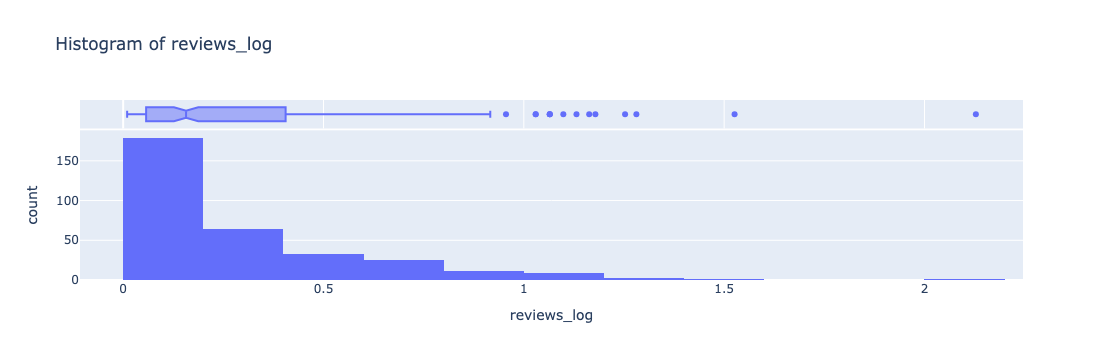

In [2489]:
univariate('reviews_log', outliers = 'yes')

zone             state           city                         name  \
72    Western           Gujarat  Rann of Kutch                   Rann Utsav   
161  Northern  Himachal Pradesh    Bir Billing             Paragliding Site   
68    Western           Gujarat       Junagadh            Gir National Park   
47    Eastern       West Bengal        Kolkata                 Eden Gardens   
315   Central     Uttar Pradesh  Greater Noida  Buddh International Circuit   

                type     year  time  rating   fee airport  ... reviews  \
72          Cultural  Unknown   3.0     4.9  7500     Yes  ...    0.10   
161  Adventure Sport     2005   2.0     4.8  2500      No  ...    0.01   
68     National Park     1965   3.0     4.5  3500      No  ...    0.08   
47    Cricket Ground     1864   3.0     4.1  2500     Yes  ...    0.10   
315       Race Track     2011   2.0     4.6  1500     Yes  ...    7.40   

       visit camera_num  airport_num year_num   cost_ratio  rating_norm  \
72   Evening          1            1      NaN  2500.000000     1.509522   
161  Anytime          1            0   2005.0  1250.000000     1.144767   
68   Morning          1            0   1965.0  1166.666667     0.050504   
47   Anytime          1            1   1864.0   833.333333    -1.408513   
315  Anytime          1            1   2011.0   750.000000     0.415259   

      fee_log  reviews_log  cost_ratio_log  
72   8.922792     0.095310        7.824446  
161  7.824446     0.009950        7.131699  
68   8.160804     0.076961        7.062763  
47   7.824446     0.095310        6.726633  
315  7.313887     2.128232        6.621406  

[5 rows x 23 columns]

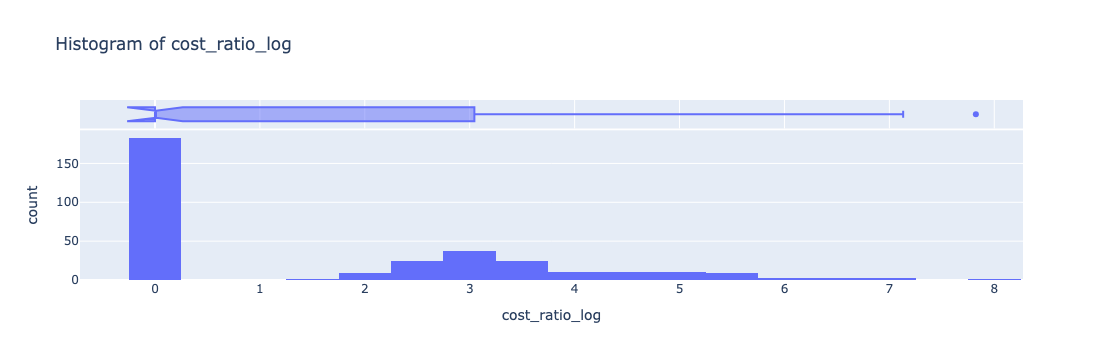

In [2491]:
univariate('cost_ratio_log', outliers = 'yes')

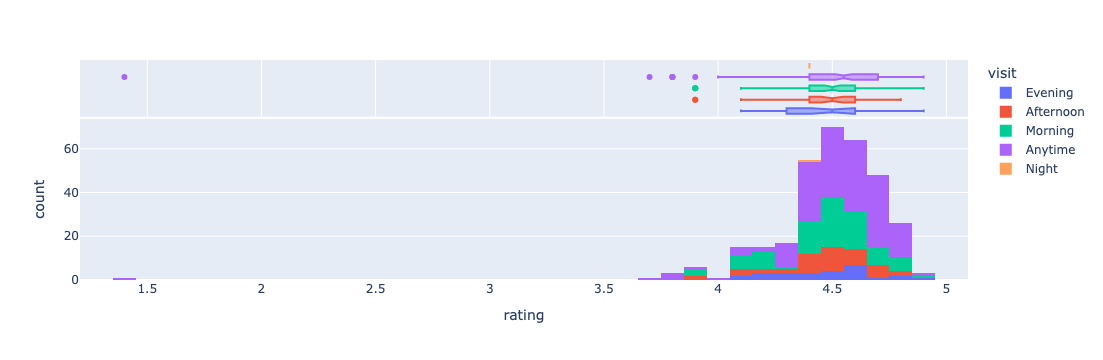

In [839]:
x = 'rating'

px.histogram(df, x=x, marginal = 'box', color = 'visit')

In [2534]:
def corr_matrix(x = None, y = None, df=df):
    """
    Display correlation dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation table
    
    """

    #Apply correlation matrix to entire dataframe, unless x and y variables are provided for filter
    if x == None:
        df = df
    else:
        df = df[df[x] == y]

    #Set plot size
    plt.figure(figsize=(8,6))

    #Create correlation matrix
    corr_matrix = df.corr(numeric_only = True)

    #Convert correlation matrix to heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

    #Set correlation matrix title
    plt.title('Correlation Matrix')

    #display correlation matrix
    plt.show()

def corr_table(x = None, y = None, df=df, t_min = 0.3, t_max = 1):
    """
    Display correlation dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation table
    
    """
    #Apply correlation matrix to entire dataframe, unless x and y variables are provided for filter
    
    
    if x == None:
        df = df
    else:
        df = df[df[x] == y]

    #Create correlation matrix
    corr = df.corr(numeric_only = True)

    #convert correlation matrix into list of lists
    result = []
    for row in corr.index:
        for col in corr:
            if row != col:
                result.append([row, col, corr[col][row]])
    
    #convert list into dataframe
    corr_df = pd.DataFrame(result, columns = ['var_1','var_2','corr'])

    #Sort dataframe on correlation
    corr_df = corr_df.sort_values('corr', ascending = False)
    
    #Filter variables that are directly correlated 
    corr_df = corr_df[~(corr_df['var_1'].str.contains('rating') & corr_df['var_2'].str.contains('rating'))]
    corr_df = corr_df[~(corr_df['var_1'].str.contains('cost|fee') & corr_df['var_2'].str.contains('cost|fee'))]
    corr_df = corr_df[~(corr_df['var_1'].str.contains('reviews') & corr_df['var_2'].str.contains('reviews'))]

    #Filter duplicate rows
    corr_df = corr_df.iloc[::2]

    #Filter by minimum and maximum correlation threshold
    corr_df = corr_df[(abs(corr_df['corr']) > t_min) & (abs(corr_df['corr']) <= t_max)]

    #Add columns for category and type
    corr_df['category'] = x
    corr_df['type'] = y

    return corr_df


def corr_info(x = None, y = None, df = df, t_min = 0.3, t_max = 1):
    """
    Display correlation matrix and dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation matrix with heatmap
    
    Correlation table
    
    """
    #Display correlation matrix
    corr_matrix(x, y, df)

    #Display correlation table
    display(corr_table(x, y, df, t_min, t_max))

def corr_cat(x, t_min=0.3, t_max = 1, df=df, f = 3):
    """
    Combine correlation tables across a single variable.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    df : dataframe, optional
        The dataframe to analyze, default value = df
    f : int, optional
        Count of elements by which to filter, default value = 3
    
    Returns
    -------
    
    Combined correlation table
    
    """
    #Create empty dataframe
    corr_cat_df = pd.DataFrame()

    #Filter grouped dataframe by element count
    df = df.groupby(x, observed = False).filter(lambda x: len(x) > f)

    #Loop through types within category, combine dataframes
    for y in df[x].unique():
        temp_df = corr_table(x, y, t_min=t_min, t_max=t_max, df=df)
        corr_cat_df = pd.concat([corr_cat_df, temp_df], axis = 0)

    #Return combined dataframe
    return corr_cat_df

def corr_total(t_min = 0.9, t_max = 1, f = 10, df=df):
    """
    Combine correlation tables across all variables.
    
    Parameters
    ----------
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.9
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    f : int, optional
        Count of elements by which to filter, default value = 10
    
    Returns
    -------
    
    Combined correlation table
    
    """
    #Create empty dataframe
    corr_total_df = pd.DataFrame()

    #Loop through variables within dataframe, combine dataframes
    for x in df.loc[:, df.columns != 'year'].select_dtypes(exclude='number').columns:
        temp_df = corr_cat(x, t_min=t_min, t_max=t_max, f = f, df=df)
        corr_total_df = pd.concat([corr_total_df, temp_df], axis = 0)

    #Sort dataframe on correlation
    corr_total_df = corr_total_df.sort_values('corr', ascending = False)

    #Return combined dataframe
    return corr_total_df

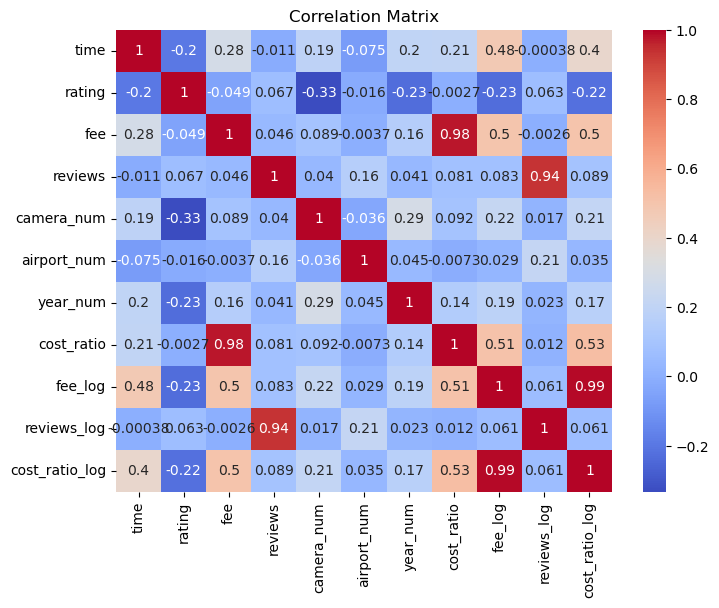

var_1           var_2      corr category  type
7         time         fee_log  0.475350     None  None
9         time  cost_ratio_log  0.395343     None  None
41  camera_num          rating -0.333549     None  None

In [2495]:
corr_info()

In [2568]:
corr_total(df=df.drop(['rating_norm', 'reviews', 'fee', 'cost_ratio', 'camera_num', 'airport_num'], axis = 1), t_min = .6, f = 20)

var_1    var_2      corr      category          type
2  time  fee_log  0.659382          type          Fort
2  time  fee_log  0.649772          zone       Eastern
2  time  fee_log  0.634382  significance  Recreational
2  time  fee_log  0.619755          zone       Western

Heatmap for presentation

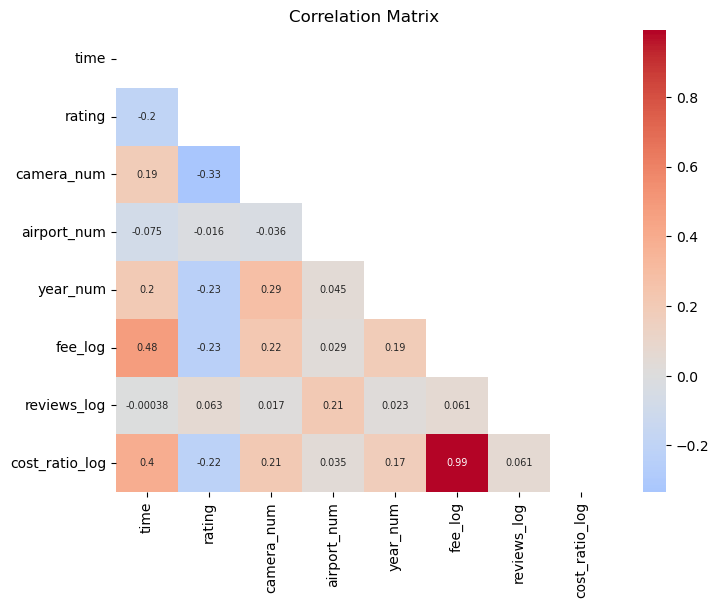

In [2517]:
x = None
y = None
temp_df = df.drop(['rating_norm', 'reviews', 'fee', 'cost_ratio'], axis = 1)

#Set plot size
plt.figure(figsize=(8,6))

#Create correlation matrix
corr_matrix = temp_df.corr(numeric_only = True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

#Convert correlation matrix to heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, annot_kws = {'size': 7}, center = 0)

#Set correlation matrix title
plt.title('Correlation Matrix')

#display correlation matrix
plt.show()

In [2511]:
df.drop(['rating_norm', 'reviews'], axis = 1)

zone           state         city                          name  \
0    Northern           Delhi        Delhi                    India Gate   
1    Northern           Delhi        Delhi                Humayun's Tomb   
2    Northern           Delhi        Delhi             Akshardham Temple   
3    Northern           Delhi        Delhi          Waste to Wonder Park   
4    Northern           Delhi        Delhi                 Jantar Mantar   
..        ...             ...          ...                           ...   
320   Western         Gujarat  Gandhinagar                    Akshardham   
321   Central   Uttar Pradesh         Agra                     Agra Fort   
322   Central  Madhya Pradesh       Bhopal  Madhya Pradesh Tribal Museum   
323  Northern       Rajasthan       Jaipur                   City Palace   
324  Northern       Rajasthan       Jaipur            Albert Hall Museum   

             type  year  time  rating  fee airport  ...   significance camera  \
0    War Memorial  1921   0.5     4.6    0     Yes  ...     Historical    Yes   
1            Tomb  1572   2.0     4.5   30     Yes  ...     Historical    Yes   
2          Temple  2005   5.0     4.6   60     Yes  ...      Religious     No   
3      Theme Park  2019   2.0     4.1   50     Yes  ...  Environmental    Yes   
4     Observatory  1724   2.0     4.2   15     Yes  ...     Scientific    Yes   
..            ...   ...   ...     ...  ...     ...  ...            ...    ...   
320        Temple  1992   3.0     4.6    0     Yes  ...      Religious     No   
321          Fort  1565   2.0     4.5   40     Yes  ...     Historical    Yes   
322        Museum  2013   2.0     4.7   10     Yes  ...       Cultural    Yes   
323        Palace  1727   2.0     4.4  200     Yes  ...     Historical    Yes   
324        Museum  1887   2.0     4.5  200     Yes  ...     Historical    Yes   

         visit camera_num  airport_num  year_num  cost_ratio   fee_log  \
0      Evening          1            1    1921.0         0.0  0.000000   
1    Afternoon          1            1    1572.0        15.0  3.433987   
2    Afternoon          0            1    2005.0        12.0  4.110874   
3      Evening          1            1    2019.0        25.0  3.931826   
4      Morning          1            1    1724.0         7.5  2.772589   
..         ...        ...          ...       ...         ...       ...   
320    Anytime          0            1    1992.0         0.0  0.000000   
321  Afternoon          1            1    1565.0        20.0  3.713572   
322    Anytime          1            1    2013.0         5.0  2.397895   
323    Morning          1            1    1727.0       100.0  5.303305   
324    Anytime          1            1    1887.0       100.0  5.303305   

     reviews_log  cost_ratio_log  
0       1.280934        0.000000  
1       0.336472        2.772589  
2       0.336472        2.564949  
3       0.239017        3.258097  
4       0.270027        2.140066  
..           ...             ...  
320     0.165514        0.000000  
321     0.832909        3.044522  
322     0.139762        1.791759  
323     0.412110        4.615121  
324     0.488580        4.615121  

[325 rows x 21 columns]

In [2265]:
def bivar_box(x, y, df=df, text='name', cat=None):
    """
    Display boxplots for discrete numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for outlier points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    
    Returns
    -------
    
    Box plots for each discrete number category.
    
    """
    #filter outliers
    temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #create figure
    fig = px.box(temp_df, x=x, y=y, hover_name=text, color = cat, title = y + " vs " + x)

    return fig

def outliers(x, y, df=df):
    """
    Create dataframe of outliers based on category and type.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Dataframe of outliers.
    
    """

    #create outliers dataframe, remove NaNs
    outliers_df = df[[x, y]].dropna()

    #filter outliers from dataframe
    outliers_df = outliers_df.loc[~outliers_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #merge filtered dataframe onto original dataframe
    outliers_df = outliers_df.merge(df, how = 'left', left_index = True, right_index = True, 
                              suffixes = ['', '_y'])[['name', x, y]].sort_values(by = y)
    
    return outliers_df

def bivar_sca(x, y, df=df, text = 'name', cat = None):
    """
    Display scatter plot for numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    
    Returns
    -------
    
    Scatter plot for numerical category.
    
    """
    #filter outliers
    temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #create figure
    fig = px.scatter(temp_df, x=x, y=y, color = cat, hover_name=text, title = y + " vs " + x)

    return fig


def bivariate(x, y, df=df, text = 'name', cat = None, type = 'sca'):
    """
    Display plot for numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    type : string, optional
        Type of plot to produce, default value = 'sca'
        Produce scatter plot : type = 'sca'
        Produce box plot : type = 'box'
    
    Returns
    -------
    
    Plot and outliers table.
    
    """

    #Display either scatter or box plot, depending on value of 'type'
    if type == 'sca':
        bivar_sca(x, y, df, text, cat).show()
    elif type == 'box':
        bivar_box(x, y, df, text, cat).show()
    #return outliers dataframe
    return display(outliers(x, y))
    


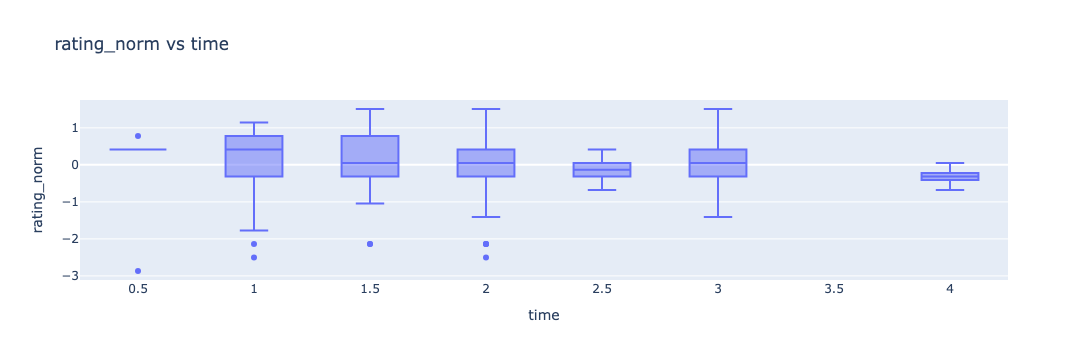

name  time  rating_norm
26                  Imagicaa   5.0   -11.256880
167          Kufri Fun World   5.0    -2.502776
24               Essel World   5.0    -0.679004
15   National Science Centre   5.0    -0.314250
78              Science City   7.0    -0.314250
200            Amarnath Cave   6.0     0.050504
110  Wonderla Amusement Park   5.5     0.415259
2          Akshardham Temple   5.0     0.415259
198             Vaishno Devi   5.0     0.780013
180        Valley of Flowers   5.0     0.780013
162              Triund Trek   5.0     1.144767

In [2267]:
bivariate('time','rating_norm', type='box')

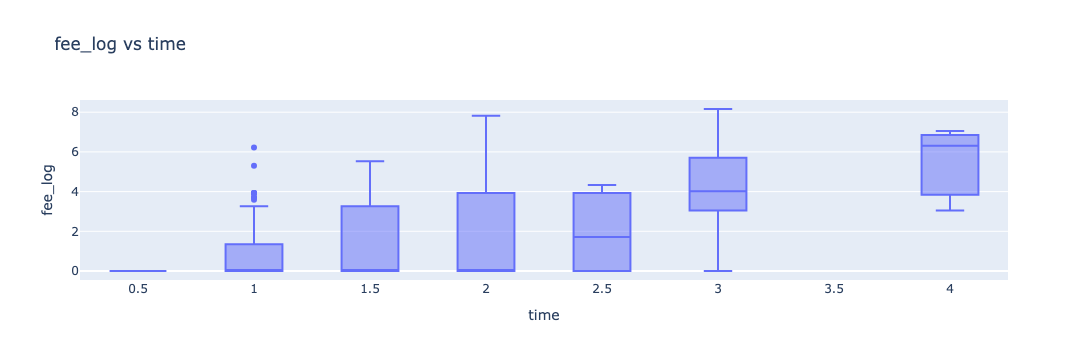

name  time   fee_log
162              Triund Trek   5.0  0.000000
200            Amarnath Cave   6.0  0.000000
198             Vaishno Devi   5.0  0.000000
2          Akshardham Temple   5.0  4.110874
15   National Science Centre   5.0  4.262680
180        Valley of Flowers   5.0  5.017280
78              Science City   7.0  6.216606
110  Wonderla Amusement Park   5.5  6.621406
24               Essel World   5.0  7.047517
26                  Imagicaa   5.0  7.047517
167          Kufri Fun World   5.0  7.313887
72                Rann Utsav   3.0  8.922792

In [2576]:
bivariate('time', 'fee_log', type='box')

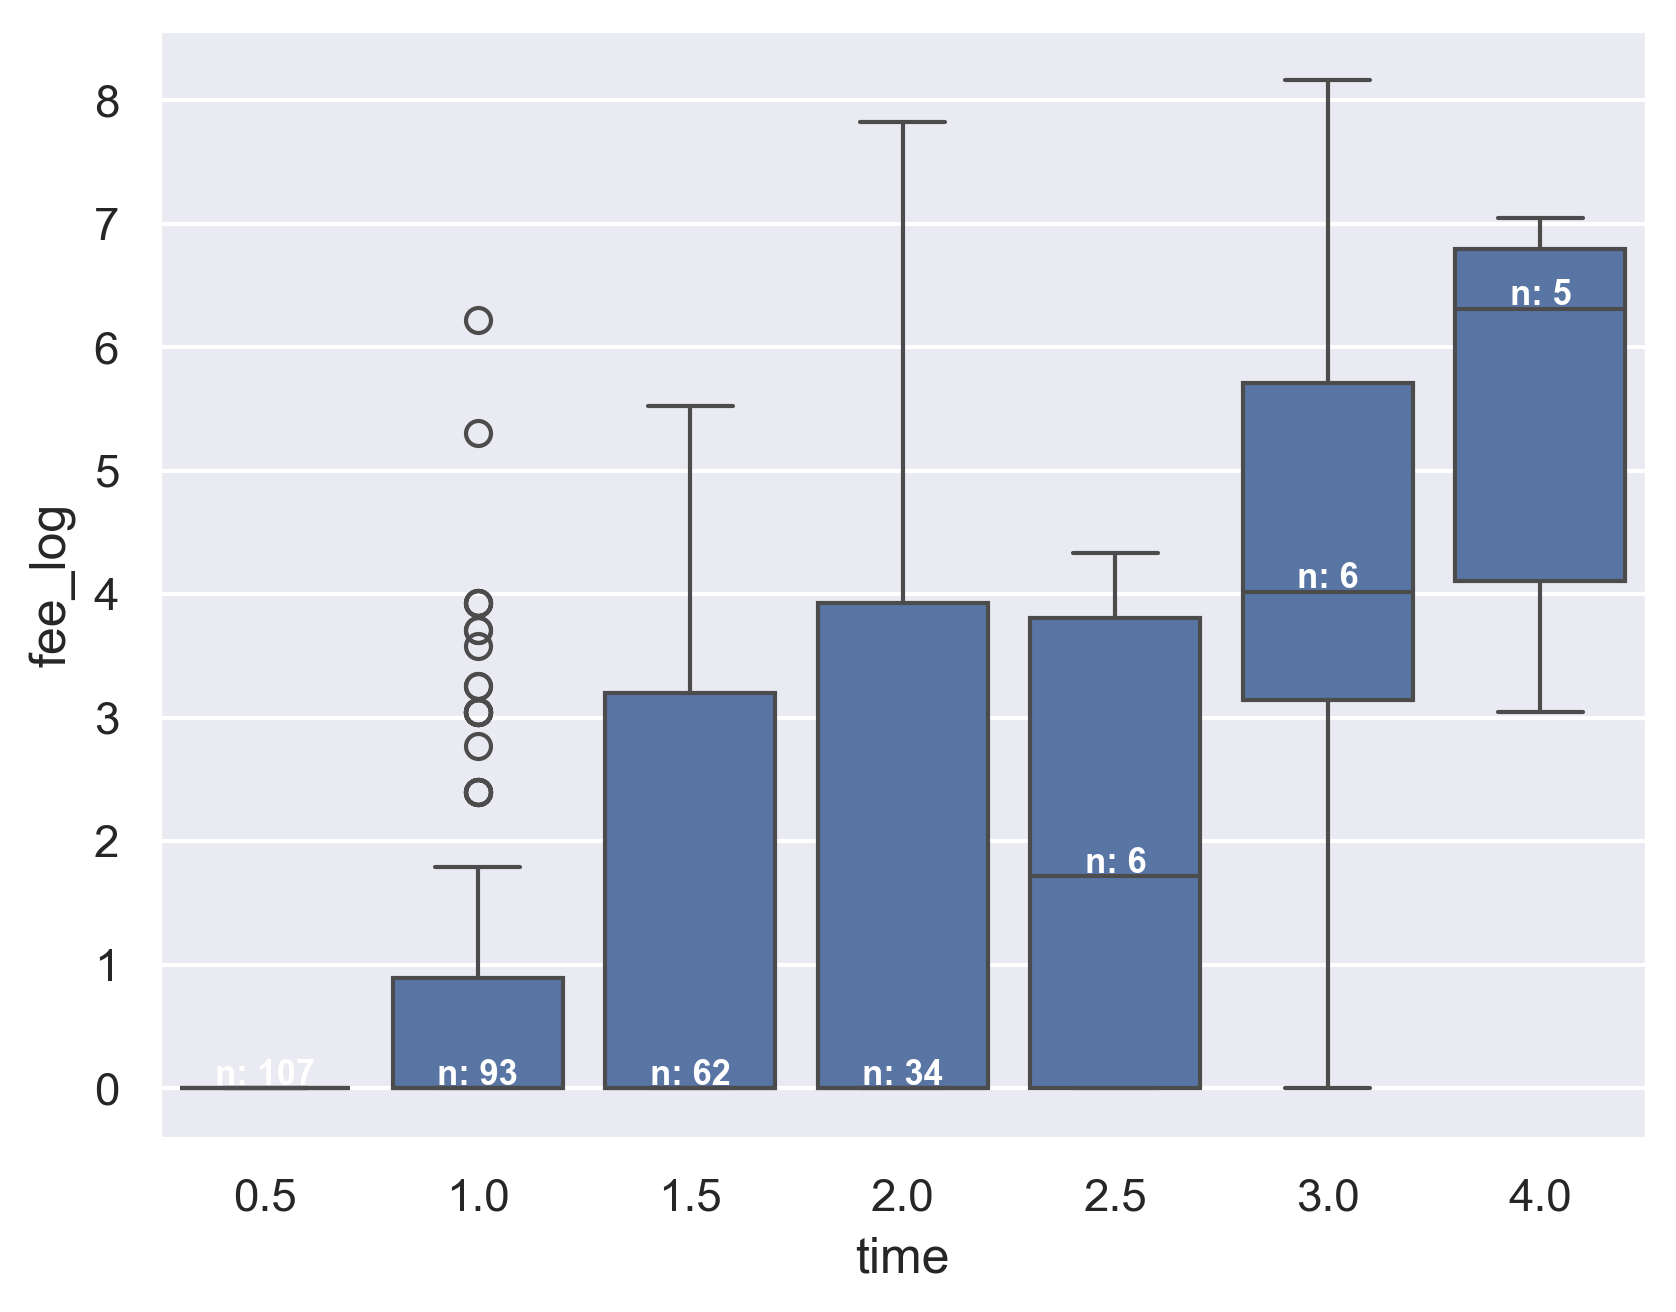

In [2586]:
sns.set_theme(style="darkgrid")

temp_df = df.loc[df[['time','fee_log']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
ax = sns.boxplot(x="time", y="fee_log", data=temp_df)
 
# Calculate number of obs per group & median to position labels
medians = temp_df.groupby(['time'])['fee_log'].median().values
nobs = temp_df['time'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            medians[tick] + 0.03,
            nobs[tick],
            horizontalalignment='center',
            size='x-small',
            color='w',
            weight='semibold')
 
plt.show()

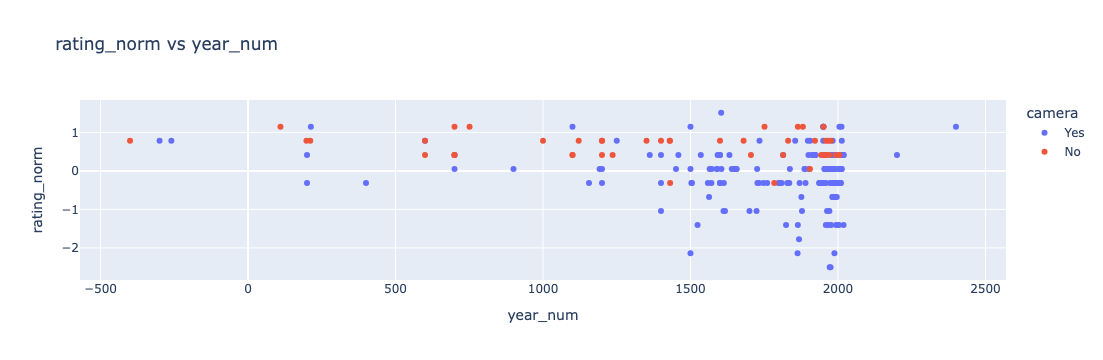

name  year_num  rating_norm
26                       Imagicaa    2013.0   -11.256880
229                 Barabati Fort    -987.0     0.050504
189                  Dhamek Stupa    -500.0     0.415259
136  Khajuraho Group of Monuments    -850.0     0.780013
174              Badrinath Temple    -820.0     1.144767
140     Mahakaleshwar Jyotirlinga   -3500.0     1.144767

In [2434]:
bivariate('year_num', 'rating_norm', cat = 'camera')

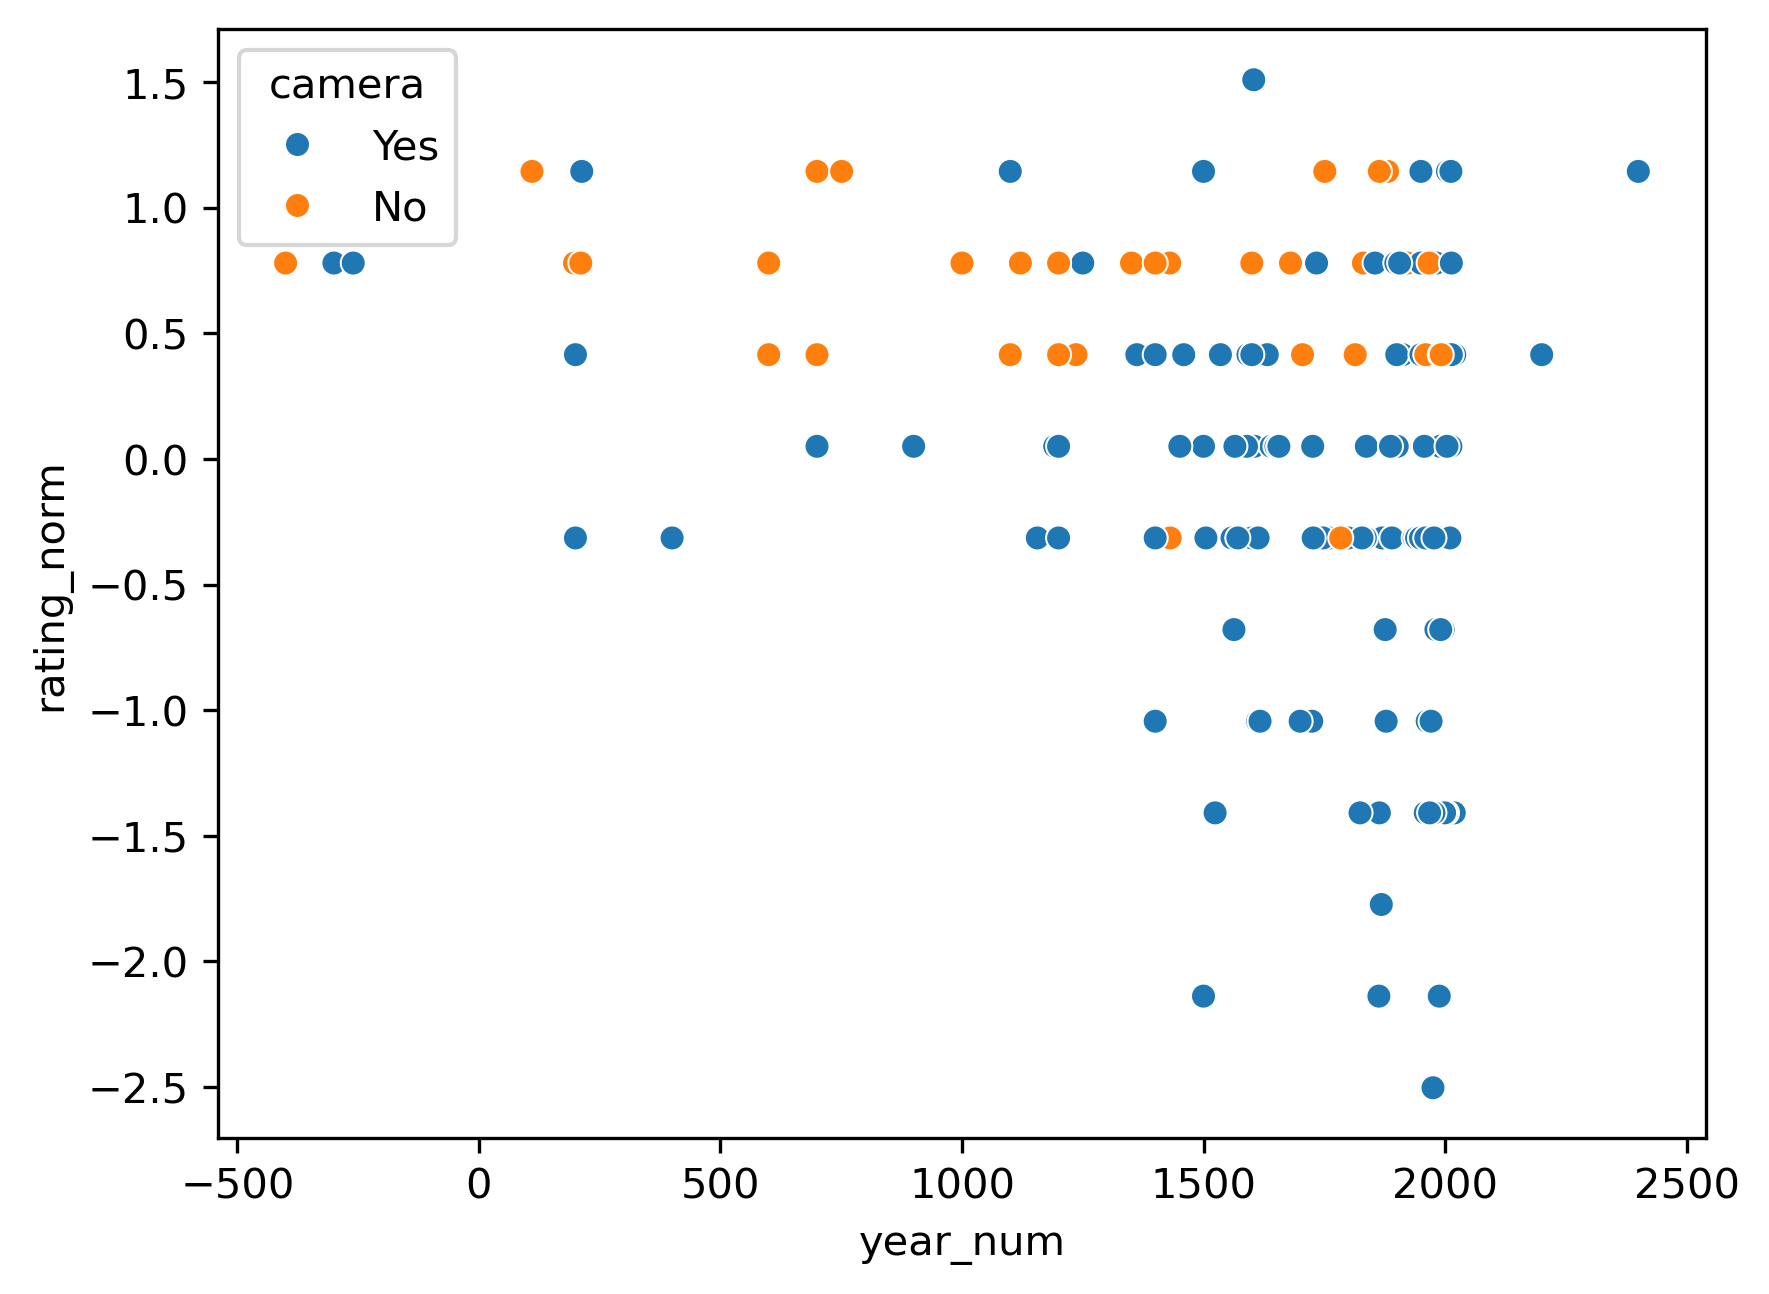

In [2556]:
plt.rcParams["figure.dpi"] = 300
x = 'year_num'
y = 'rating_norm'
temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
# Use the 'hue' argument to provide a factor variable
sns.scatterplot(
   x=x,
   y=y,
   data=temp_df,
   hue='camera',
)

plt.show()

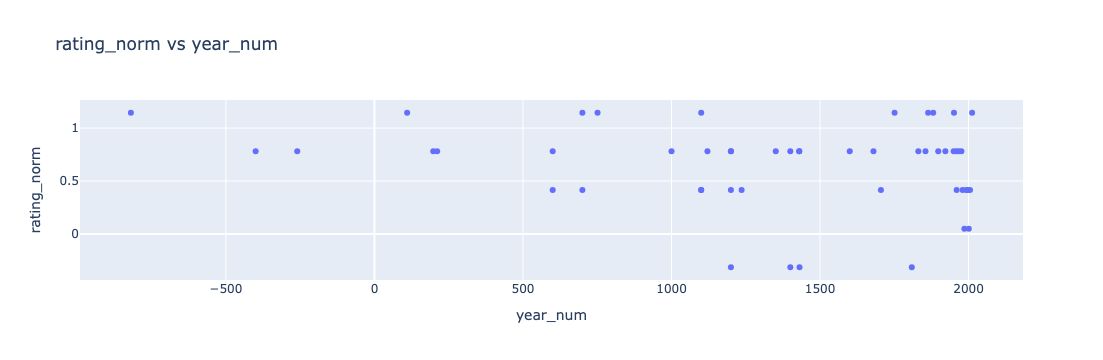

name  year_num  rating_norm
26                       Imagicaa    2013.0   -11.256880
229                 Barabati Fort    -987.0     0.050504
189                  Dhamek Stupa    -500.0     0.415259
136  Khajuraho Group of Monuments    -850.0     0.780013
174              Badrinath Temple    -820.0     1.144767
140     Mahakaleshwar Jyotirlinga   -3500.0     1.144767

In [2026]:
bivariate('year_num', 'rating_norm', df = df[df['significance'] == 'Religious'])

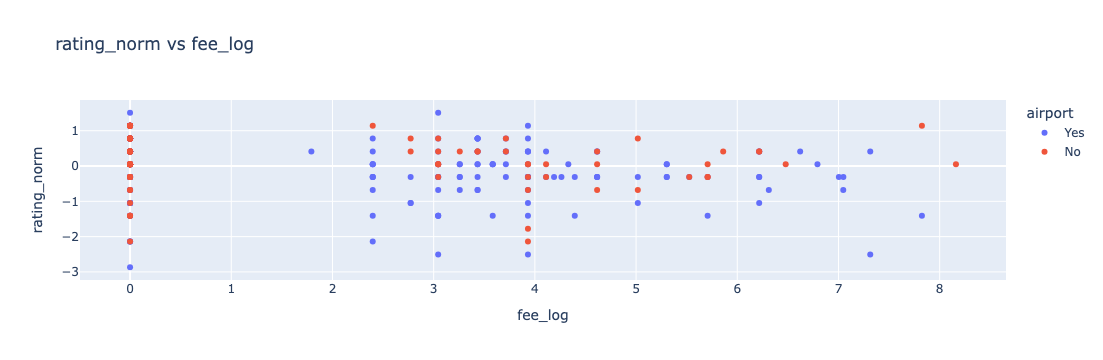

name   fee_log  rating_norm
26    Imagicaa  7.047517   -11.256880
72  Rann Utsav  8.922792     1.509522

In [2592]:
bivariate('fee_log','rating_norm', cat = 'airport')

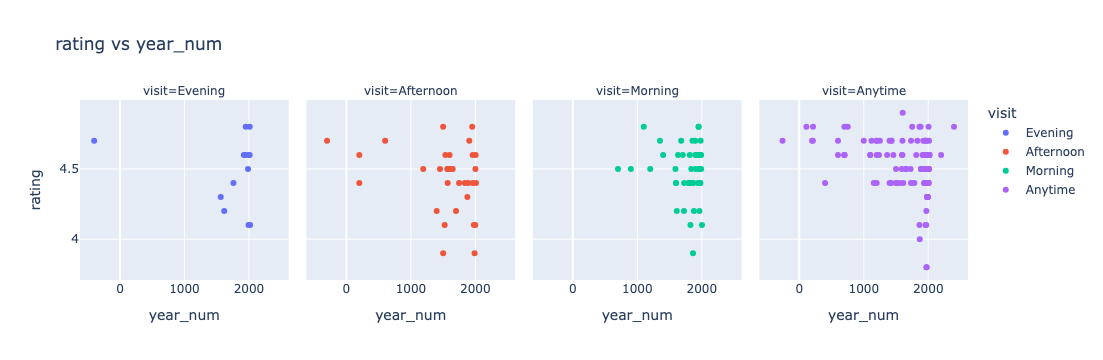

In [1804]:
x = 'year_num'
y = 'rating'
text = 'name'
cat = 'visit'

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
fig = px.scatter(temp_df, x=x, y=y, color = cat, hover_name=text, title = y + " vs " + x, facet_col = 'visit', facet_col_wrap=10)

fig.show()

In [2706]:
loc = 0
f = 13
t_min = 0.78
t_max = 1

temp_df = corr_total(t_min = t_min, t_max = t_max, f = f)

temp_df[(temp_df['var_1'] == 'rating_norm') | (temp_df['var_2'] == 'rating_norm')]

var_1        var_2      corr category  type
76      year_num  rating_norm -0.784846    state   Goa
76      year_num  rating_norm -0.784846     city   Goa
127  rating_norm     year_num -0.980883     type  Lake

state
Goa
0


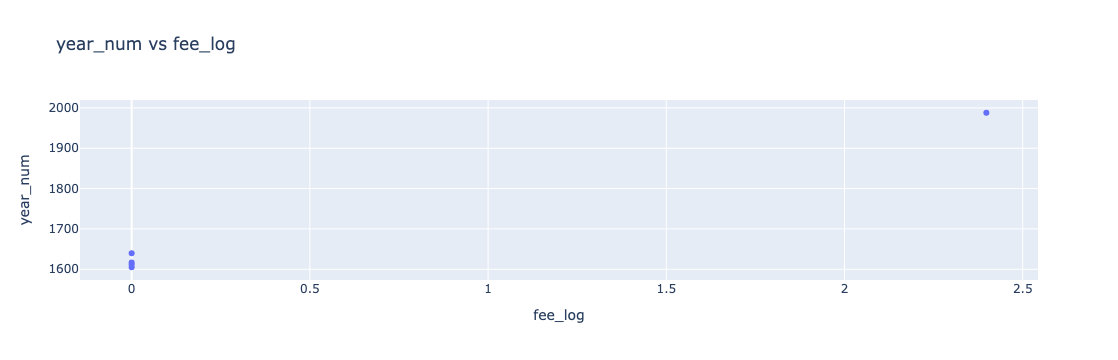

city
Goa
1


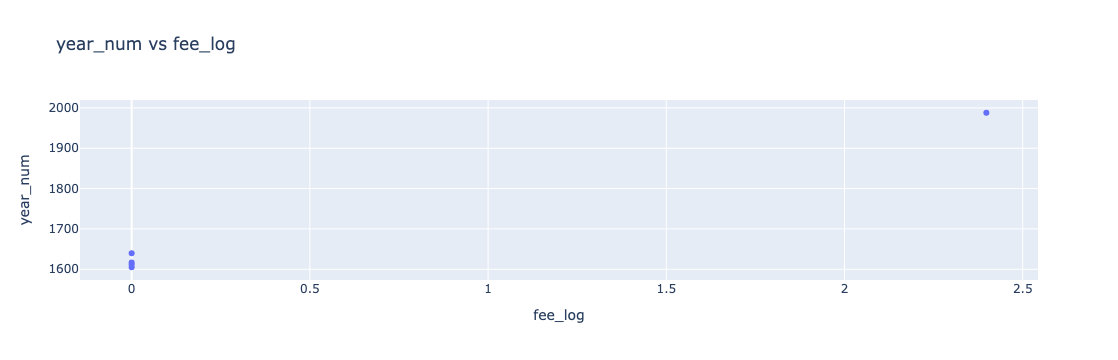

state
Goa
2


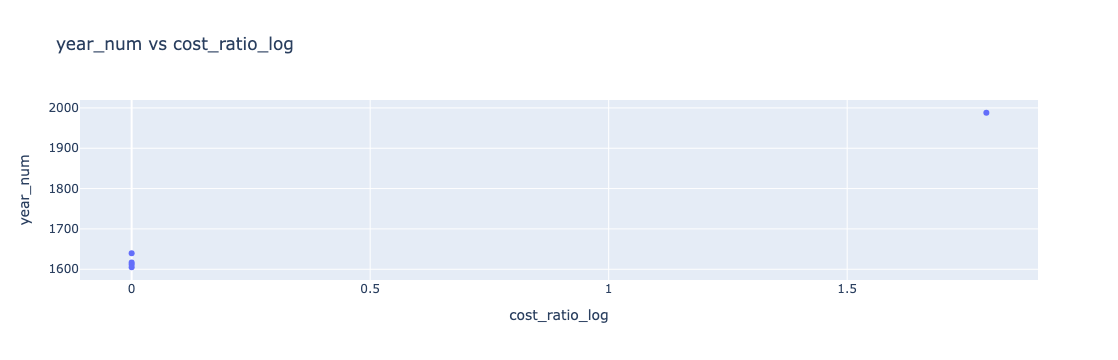

city
Goa
3


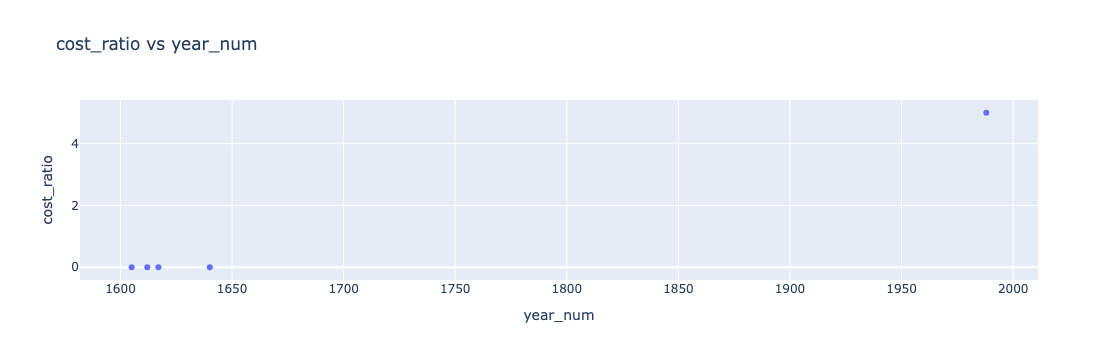

state
Goa
4


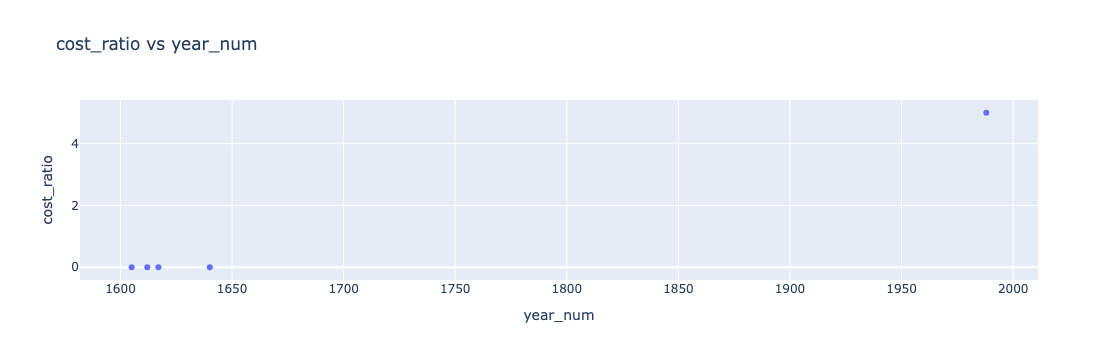

city
Goa
5


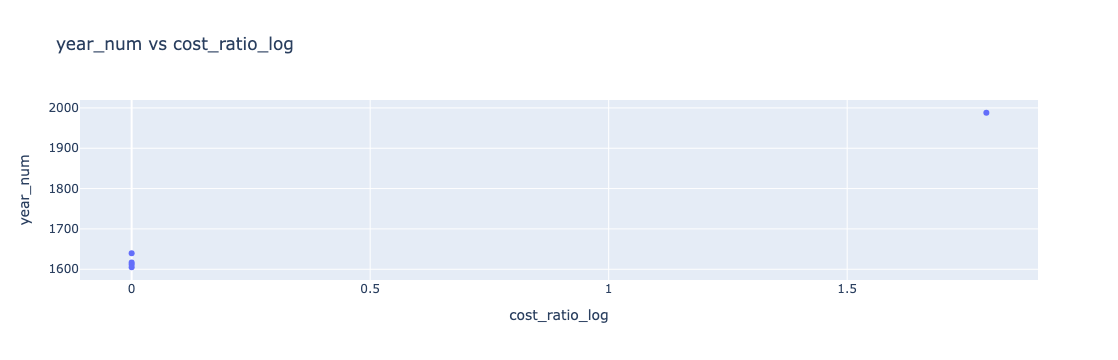

city
Goa
6


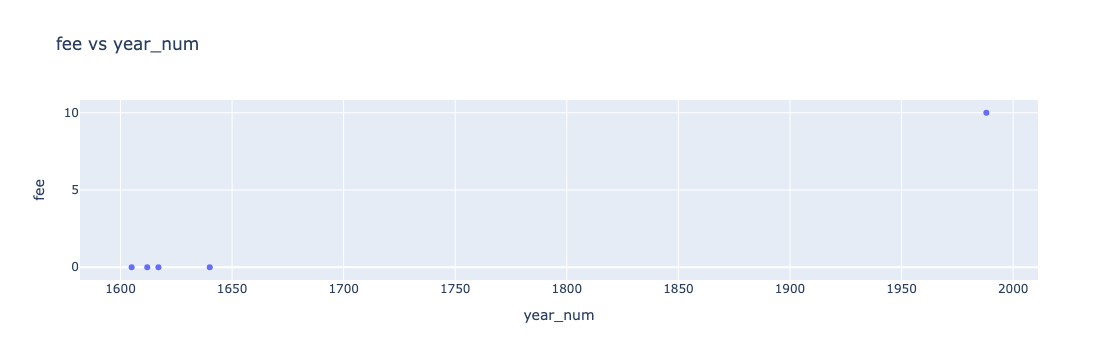

state
Goa
7


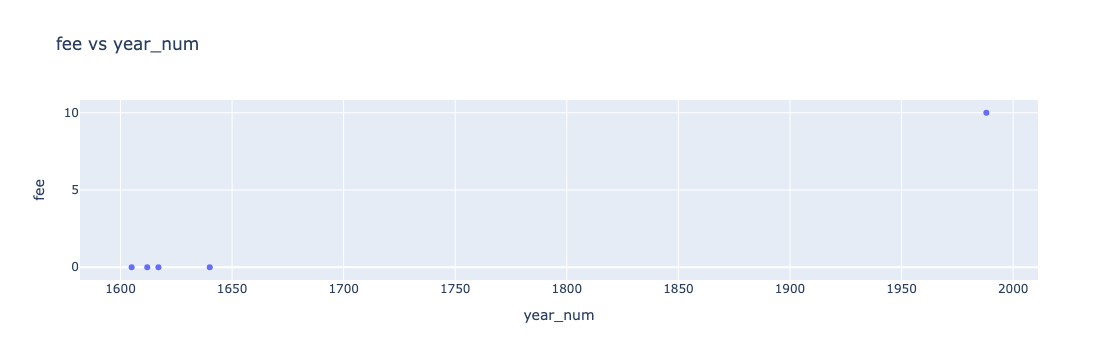

visit
Evening
8


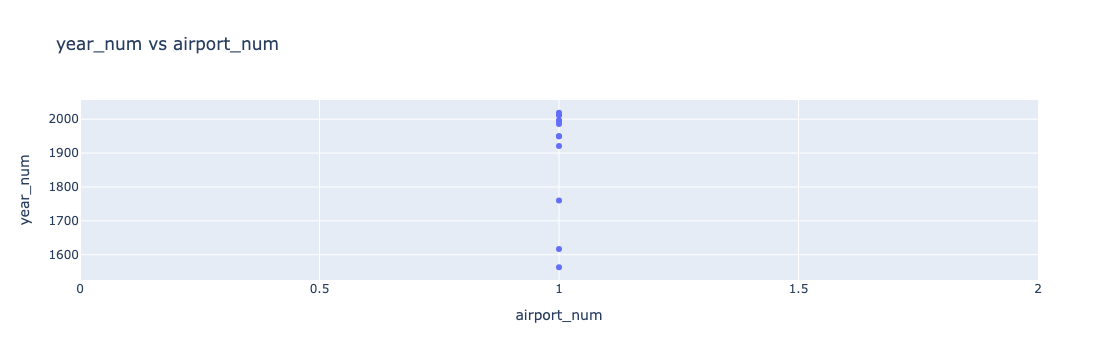

visit
Evening
9


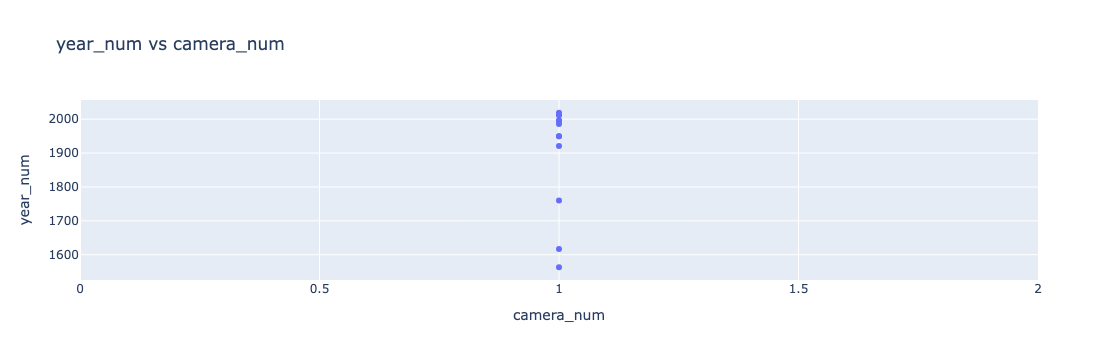

state
Uttar Pradesh
10


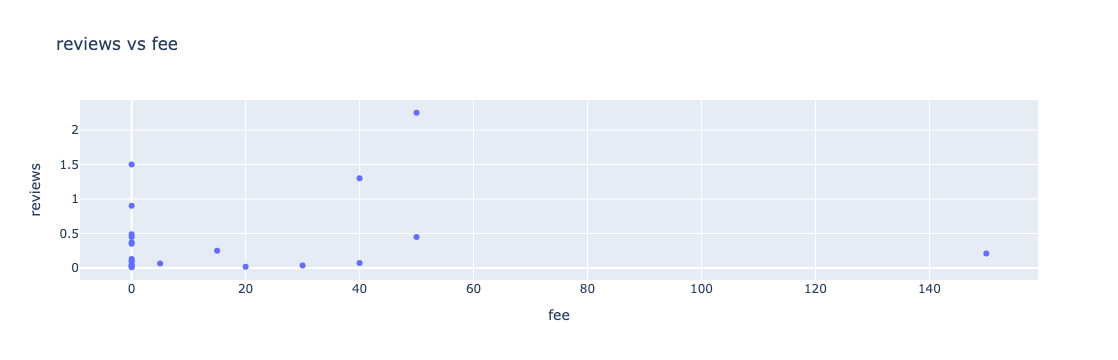

state
Uttar Pradesh
11


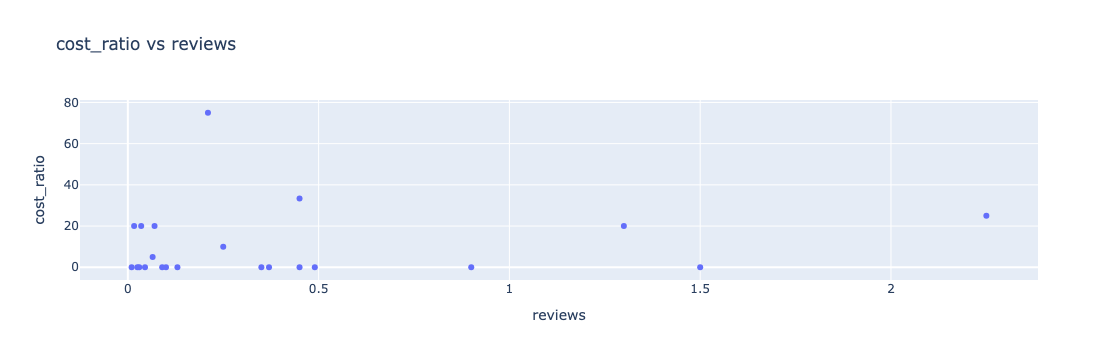

zone
Central
12


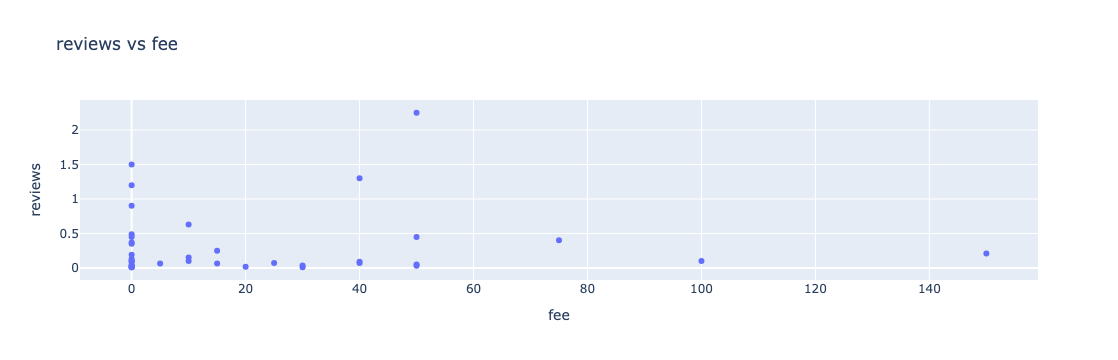

zone
Central
13


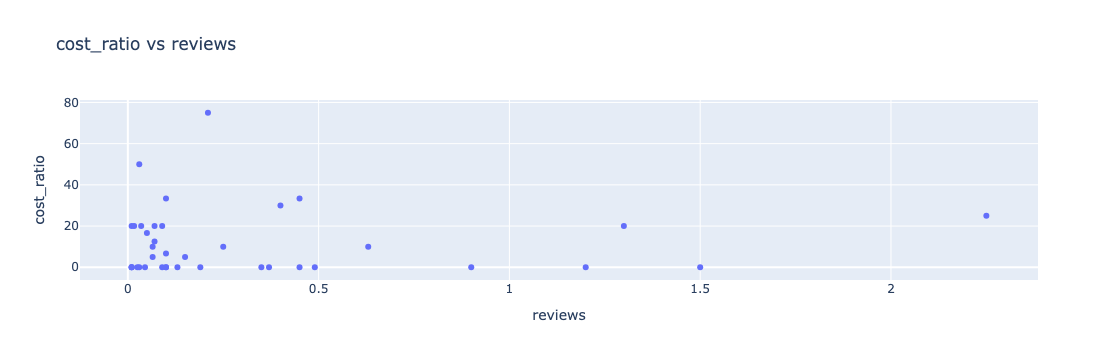

significance
Recreational
14


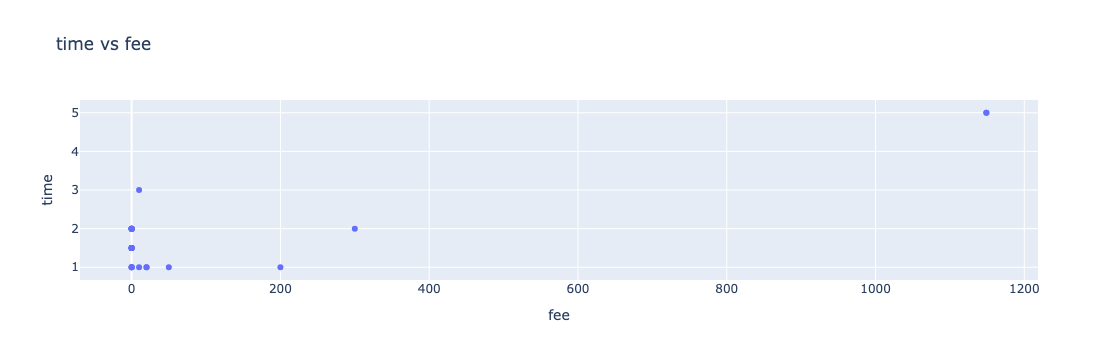

state
Goa
15


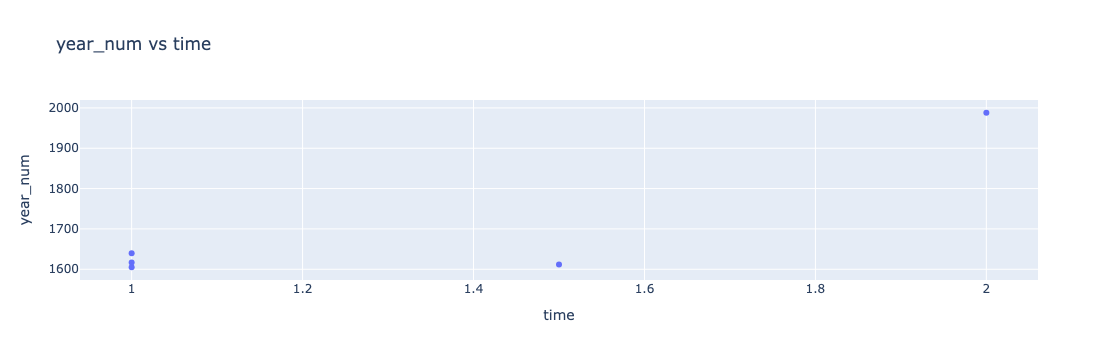

city
Goa
16


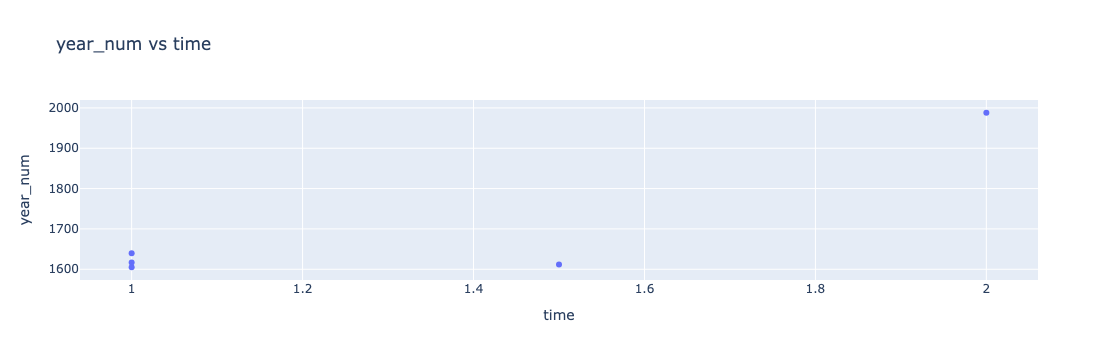

state
Kerala
17


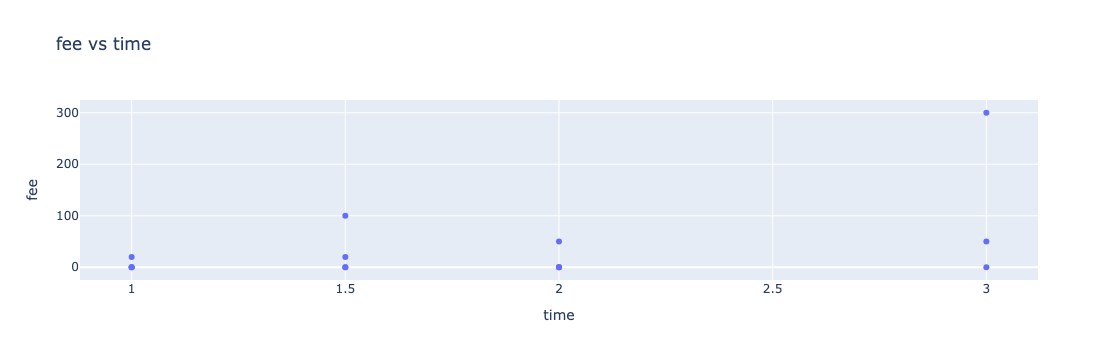

state
Madhya Pradesh
18


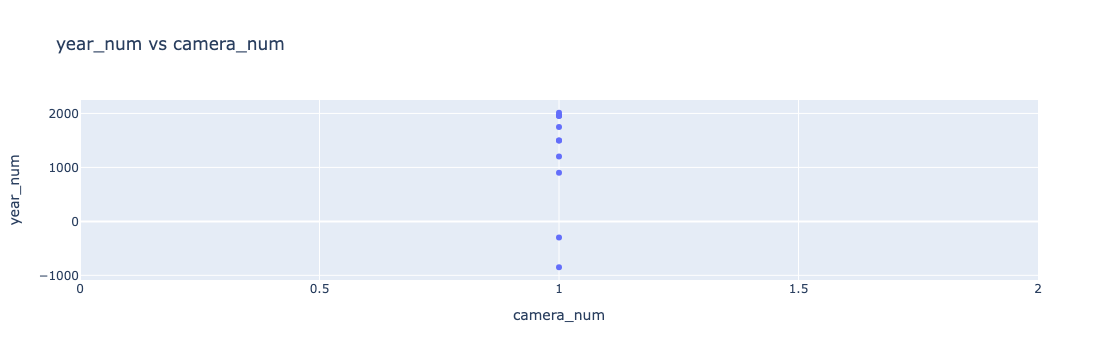

state
Maharastra
19


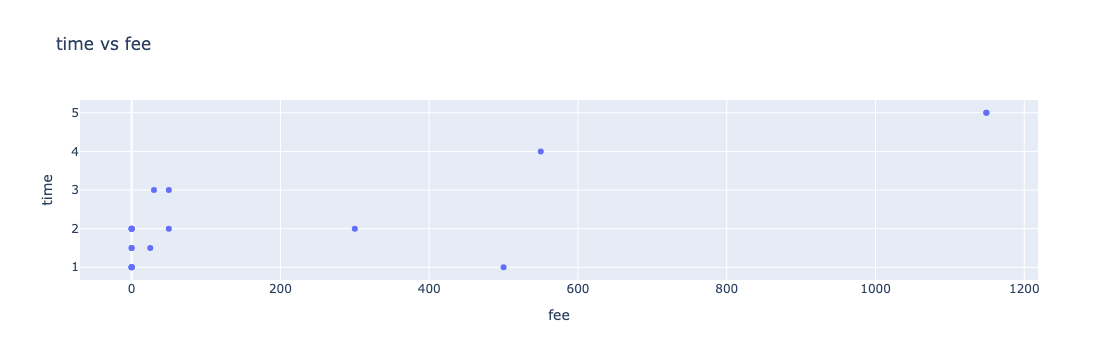

state
Karnataka
20


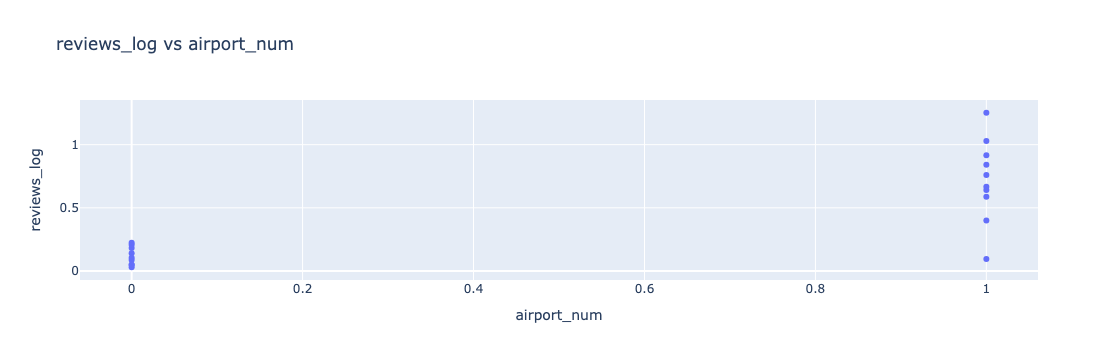

city
Goa
21


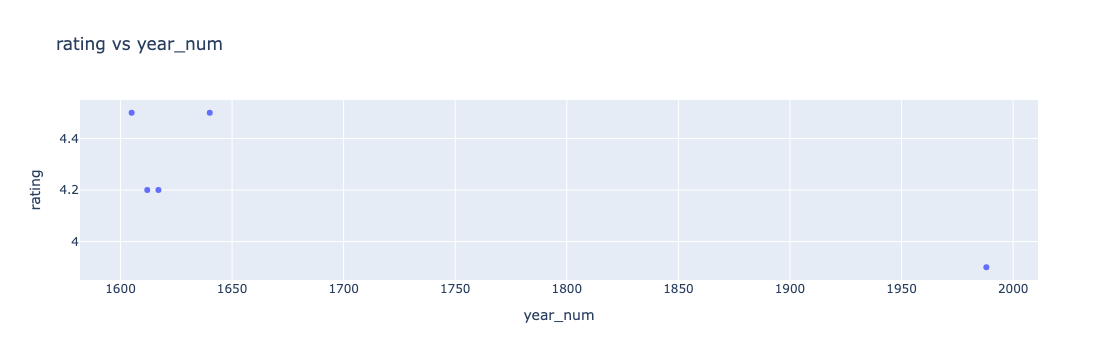

state
Goa
22


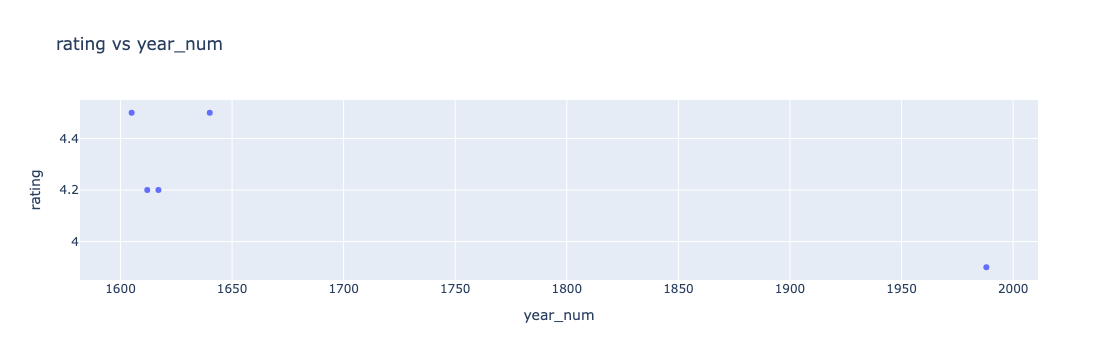

state
Goa
23


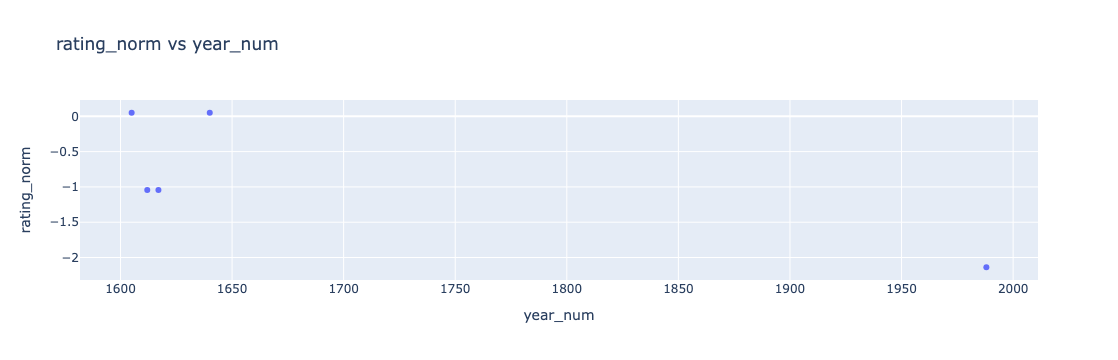

city
Goa
24


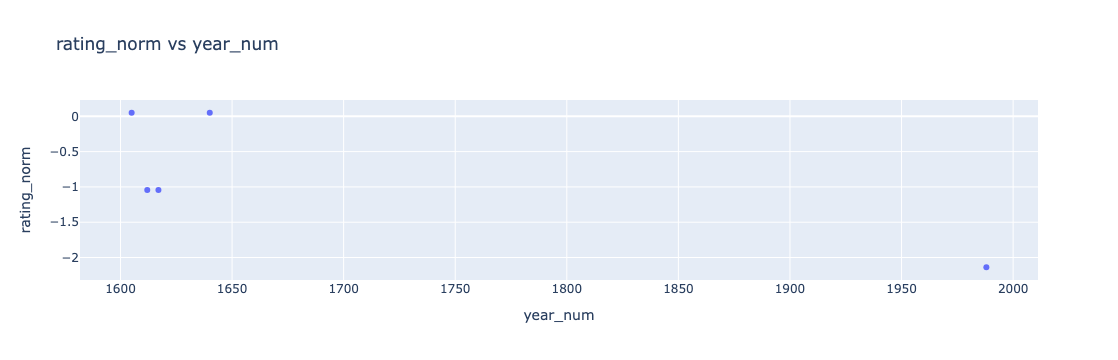

state
Madhya Pradesh
25


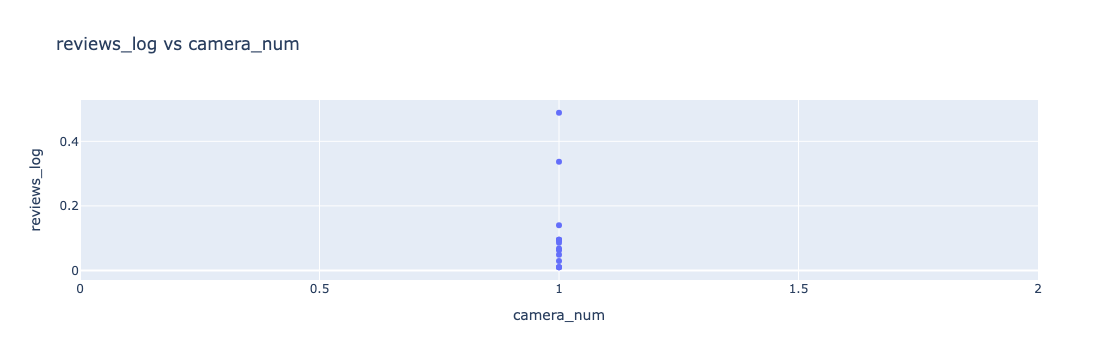

state
Madhya Pradesh
26


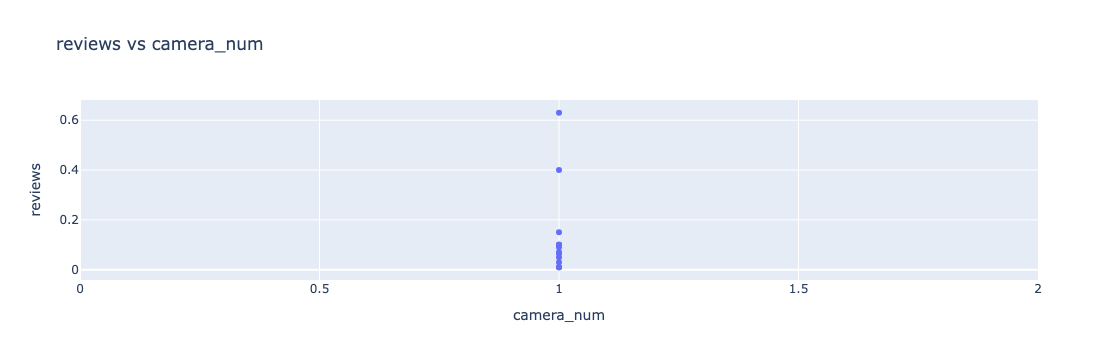

type
Lake
27


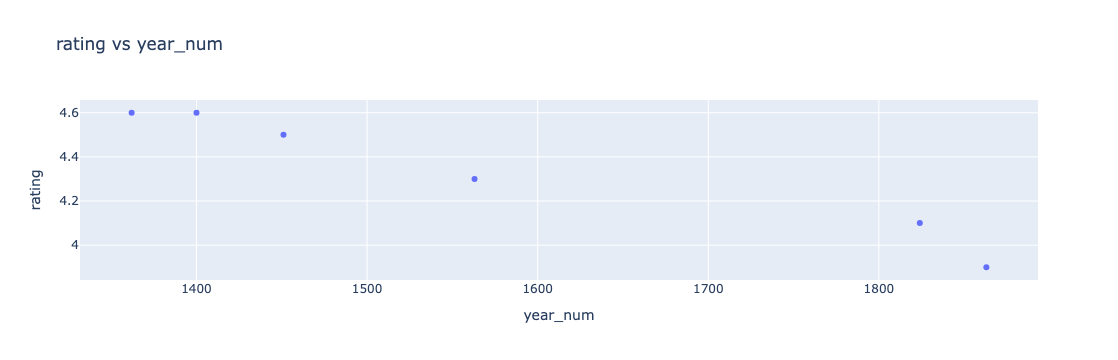

type
Lake
28


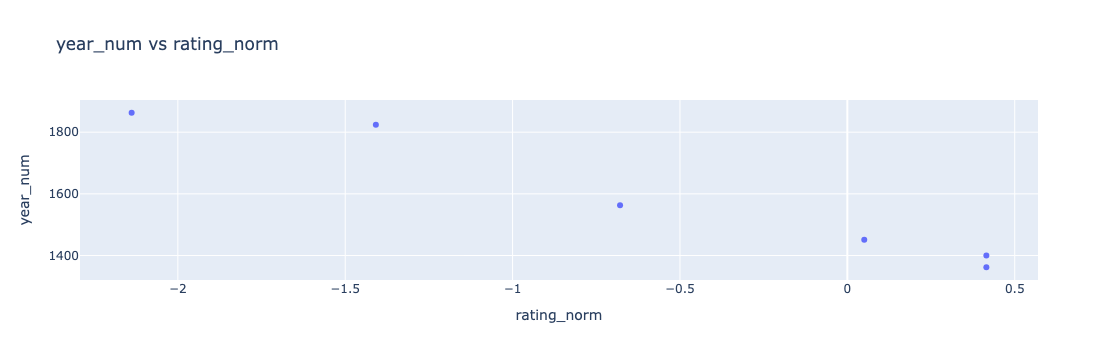

In [2708]:
loc = 0
f = 13
t_min = 0.78
t_max = 1

for loc in range(0, len(corr_total(t_min = t_min, t_max = t_max, f = f))):
    var_1, var_2, corr, category, type = corr_total(t_min = t_min, t_max = t_max, f = f).iloc[loc]
    print(category)
    print(type)
    print(loc)
    display(bivar_sca(var_1, var_2, df = df[df[category] == type]))
    loc += 1

Categorical analysis

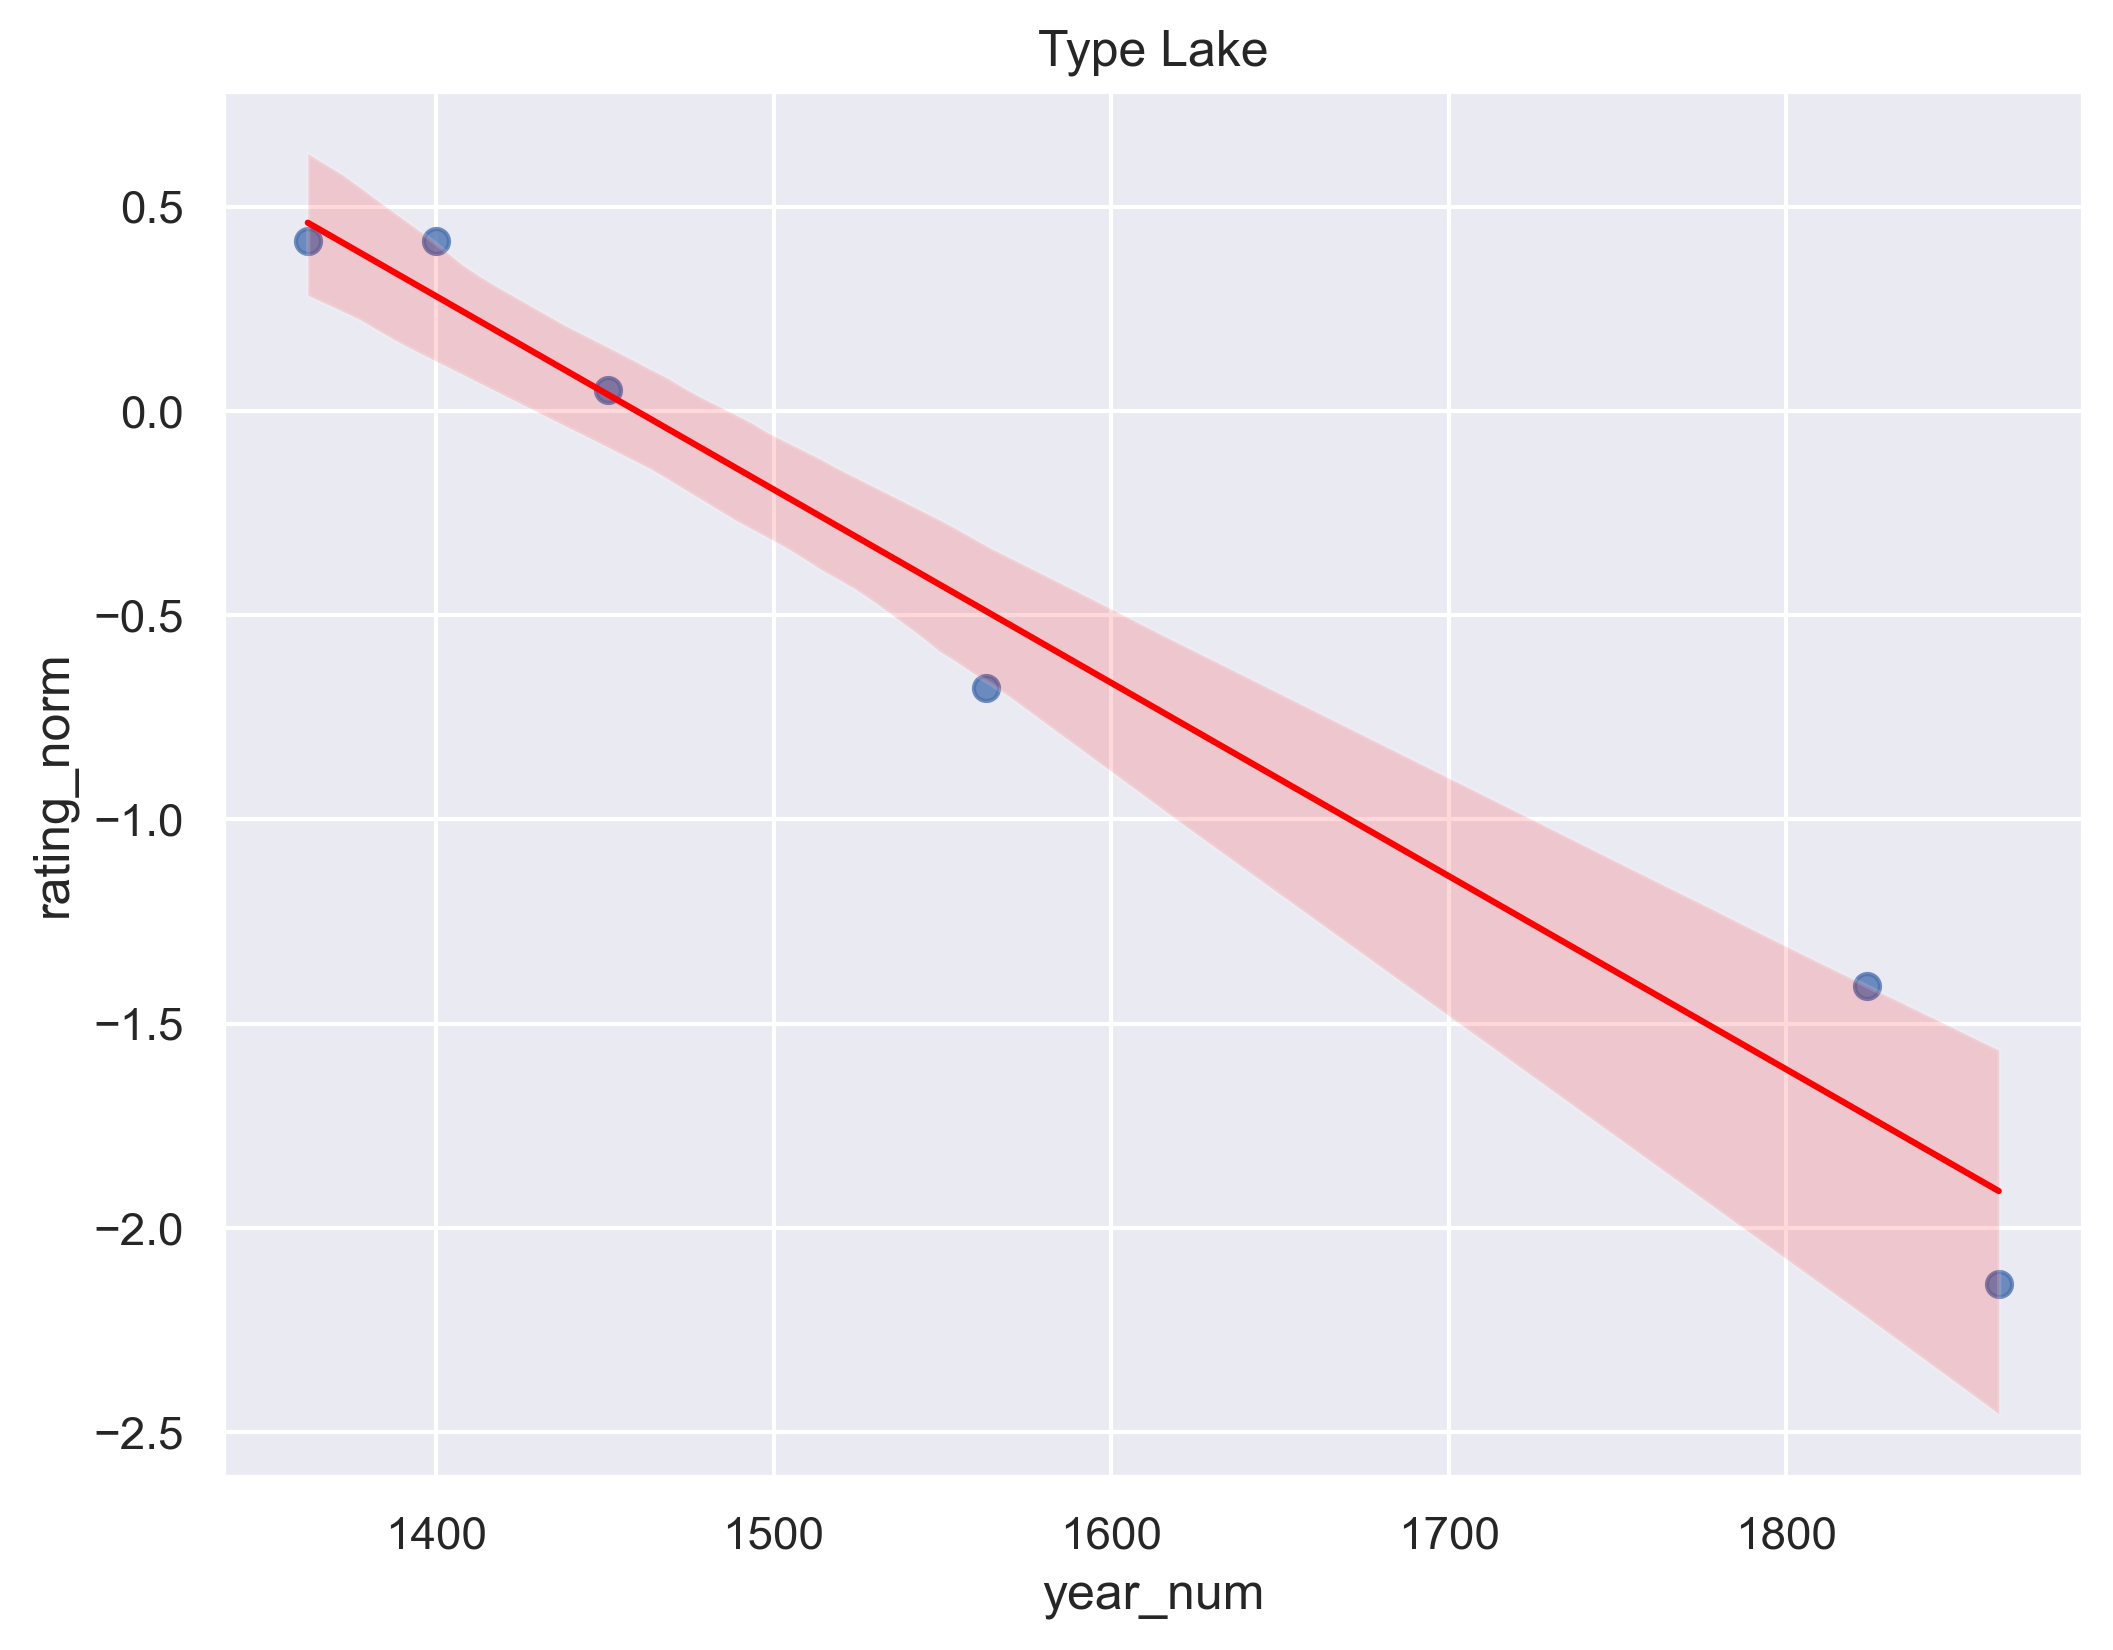

In [2674]:
fig, ax = plt.subplots(figsize=(8, 6))

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
temp_df= temp_df[temp_df['type'] == 'Lake']

sns.regplot(
    x=temp_df["year_num"],
    y=temp_df["rating_norm"],
    line_kws={"color": "red", "linewidth": 1.5},
    ax=ax,
).set(title='Type Lake')
plt.savefig("Lake.png")
plt.show()


In [2362]:
def cat_hist(x, df=df):
    """
    Create bar chart showing count of each type within variable x.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of count.
    
    """
    #filter dataframe on elements with count greater than 3
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)

    #create figure
    fig = px.histogram(temp_df, x=x).update_xaxes(categoryorder="total descending")

    return fig


def cat_bar(x, y, df=df):
    """
    Create bar chart showing average value of each type y within variable x.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the numerical element for bar value.
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of average y-value.
    
    """
    #filter dataframe on elements with count greater than 3. Compute mean y value of each type.
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    x, observed = False)[[y]].mean().sort_values(y, ascending = False).dropna()

    #create figure
    fig = px.bar(temp_df, y=y)

    #plot settings
    fig.update_layout(
        title="Average rating for each "+ x + " category",
        xaxis_title="",
        yaxis_title=y,)

    return fig

def cat_ttest(x, y, df=df):
    """
    Perform 1-sample t-test on y value of each x variable type.
    Produce a dataframe of the significant types.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y ; string
        The name of the numerical element to compute tests.
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Dataframe of significant types.
    
    """
    #create empty lists
    cat_lst = []
    p_lst = []

    #filter dataframe on elements with count greater than 3. Compute mean y value of each type.
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    x, observed = False)[[y]].mean().sort_values(y, ascending = False).dropna()

    #perform t-test on mean y of each x category.
    for category in temp_df.index:
        p = sp.stats.ttest_1samp(df[df[x] == category][y], df[y].mean())[1]
        if p < 0.05:
            cat_lst.append(category)
            p_lst.append(p)

    #combine lists into dataframe
    p_df = pd.DataFrame(list(zip(cat_lst, p_lst)), columns = ['category', 'p-value'])

    #Do not return empty dataframe
    if p_df.empty:
        pass
    else:
        return p_df
        


def categorical(x, y, df=df):
    """
    Produce bar chart of counts.
    Produce bar chart of average y value.
    Display ANOVA stats
    Display t-test dataframe.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y ; string
        The name of the numerical element to compute tests.
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of counts.
    Bar chart of average y value.
    ANOVA stats
    t-test dataframe
    
    """

    cat_hist(x, df=df).show()
    
    cat_bar(x, y, df=df).show()
    
    print(pg.anova(data=df, dv=y, between=x))
    
    temp_df = cat_ttest(x, y, df=df)
    
    
    return temp_df

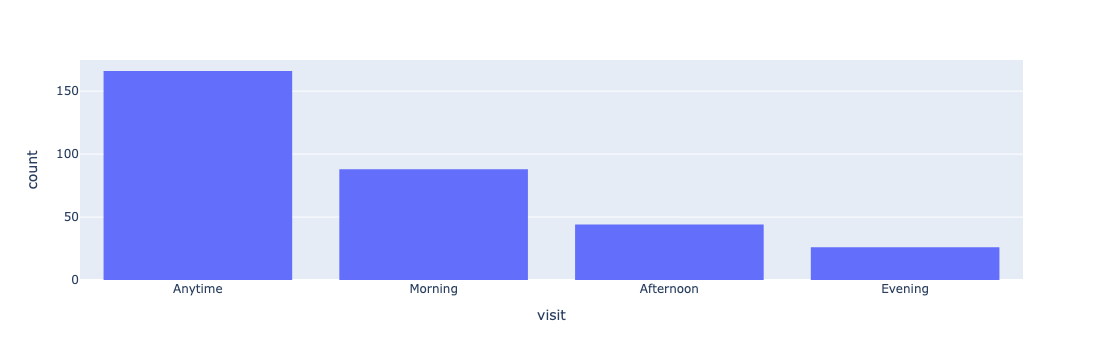

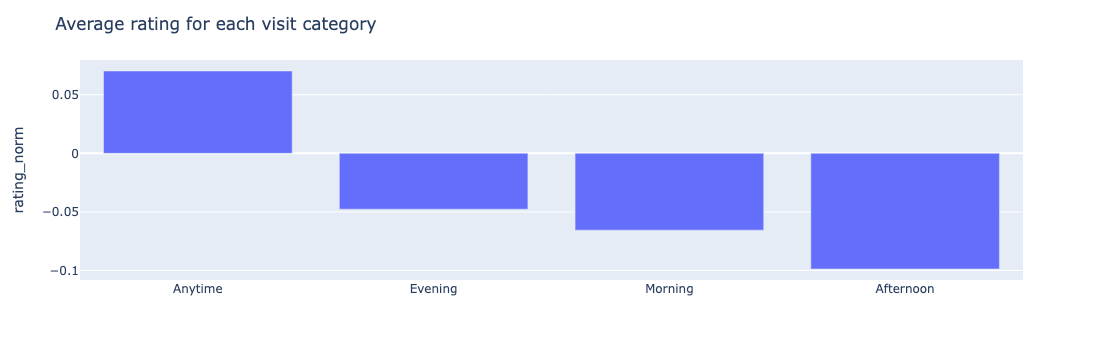

  Source  ddof1  ddof2         F   p-unc       np2
0  visit      4    320  0.441748  0.7784  0.005492


In [2364]:
categorical('visit', 'rating_norm')

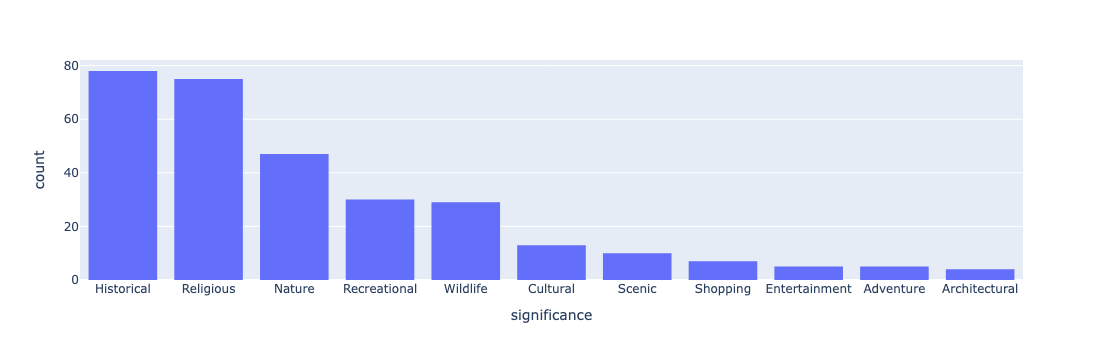

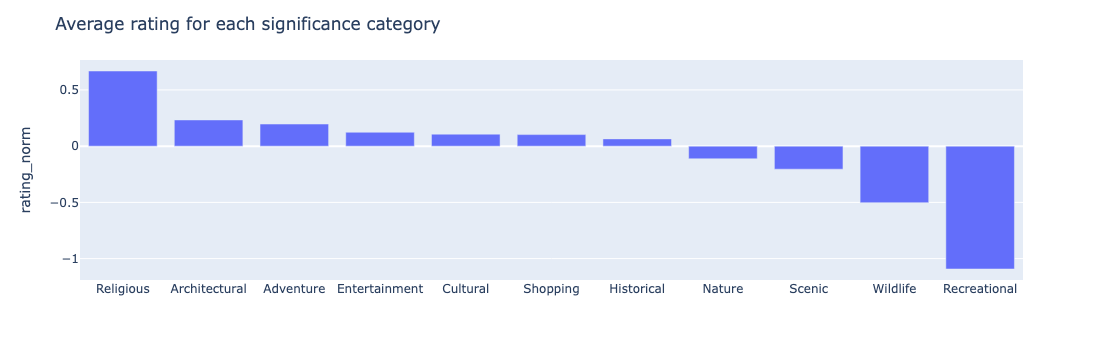

         Source  ddof1  ddof2         F         p-unc       np2
0  significance     24    300  4.714182  3.796962e-11  0.273855


category       p-value
0     Religious  5.739242e-24
1      Wildlife  3.100008e-04
2  Recreational  9.313066e-03

In [681]:
categorical('significance', 'rating_norm')

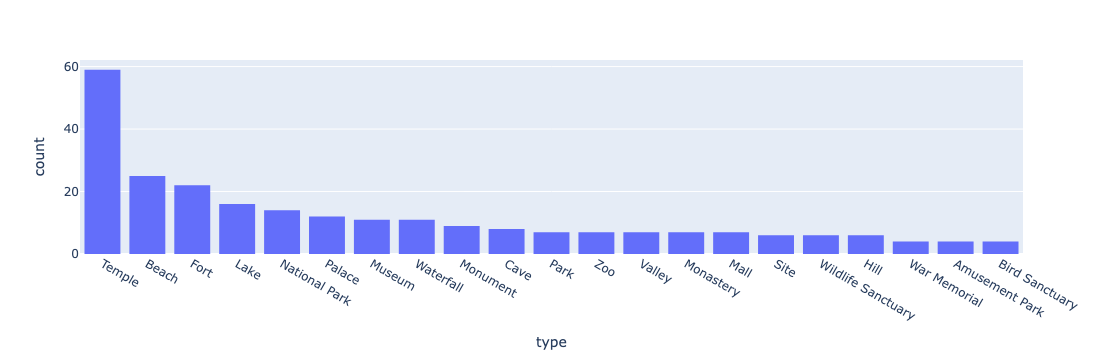

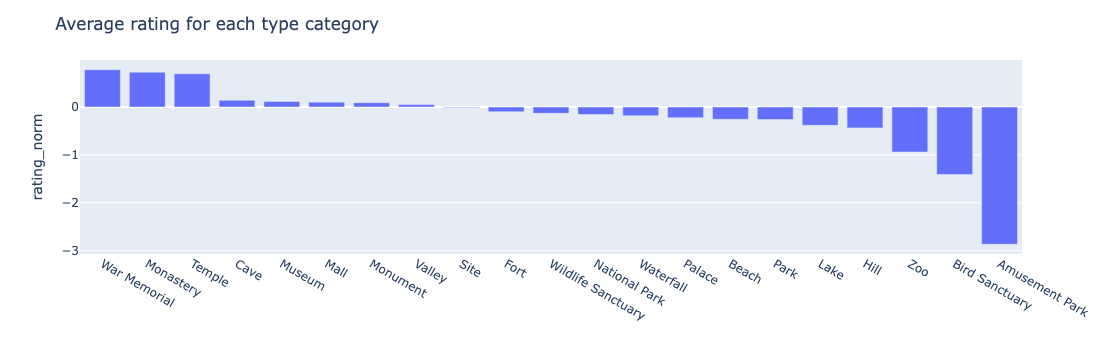

  Source  ddof1  ddof2         F         p-unc       np2
0   type     77    247  2.557954  2.177626e-08  0.443647


category       p-value
0  War Memorial  3.418494e-02
1     Monastery  2.603358e-04
2        Temple  1.221772e-20
3           Zoo  8.655803e-04

In [683]:
categorical('type', 'rating_norm')

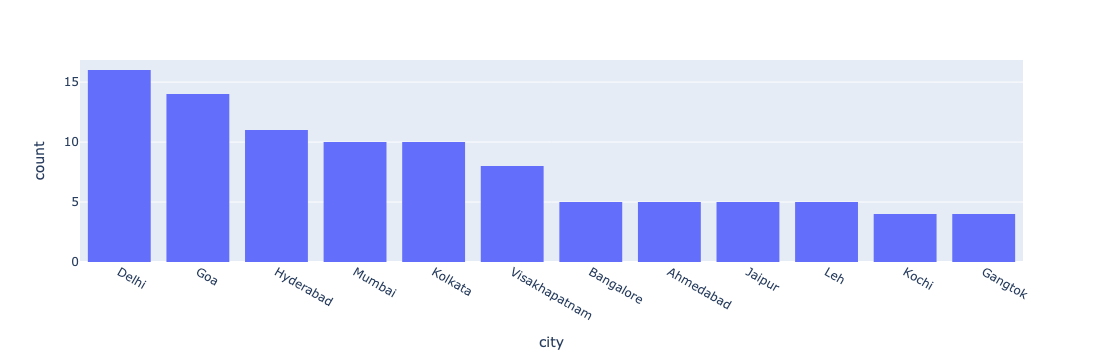

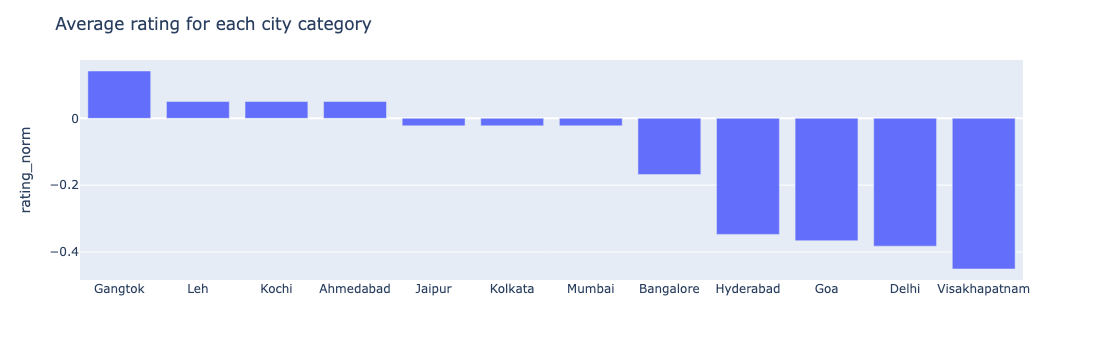

  Source  ddof1  ddof2         F     p-unc       np2
0   city    213    111  0.878711  0.788786  0.627723


category   p-value
0    Delhi  0.047074

In [685]:
categorical('city', 'rating_norm')

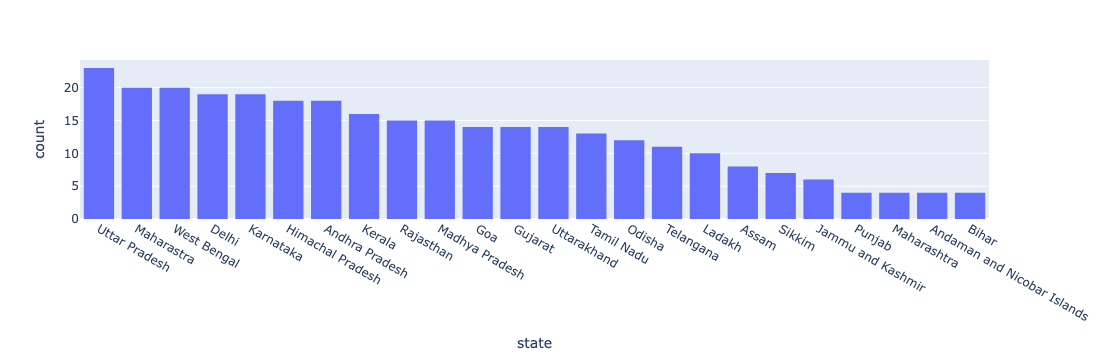

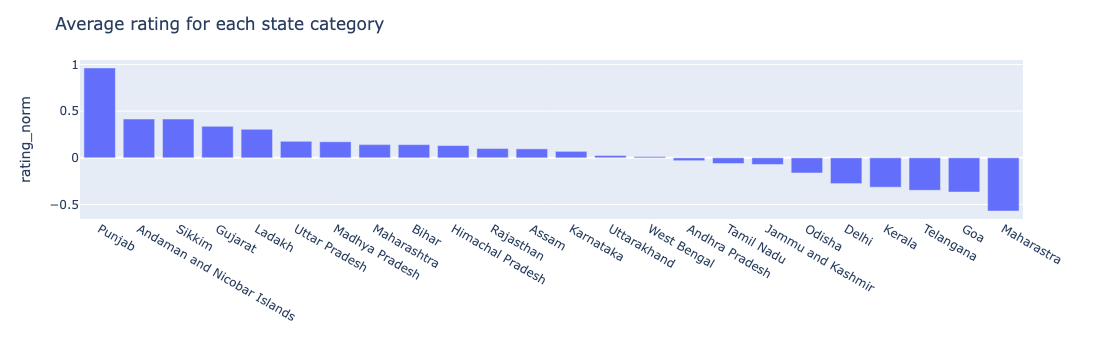

  Source  ddof1  ddof2         F     p-unc       np2
0  state     32    292  0.808365  0.761932  0.081379


category   p-value
0  Gujarat  0.035801

In [687]:
categorical('state', 'rating_norm')

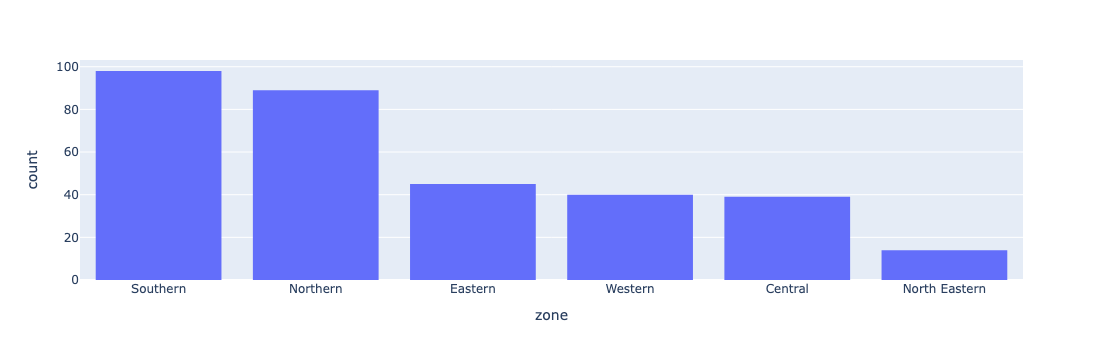

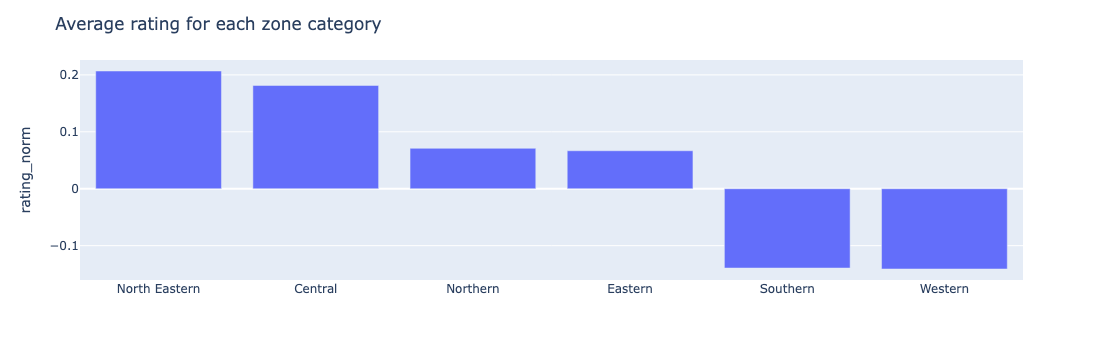

  Source  ddof1  ddof2         F    p-unc       np2
0   zone      5    319  1.043268  0.39215  0.016089


In [689]:
categorical('zone', 'rating_norm')

In [148]:
def find_min_value(function, start, end, step, var_1, var_2):
    """
    Finds the minimum value of a function within a given range.

    Args:
        function: The function to minimize.
        start: The starting point of the range.
        end: The ending point of the range.
        step: The step size for iteration.

    Returns:
        The minimum value of the function within the range.
    """

    x_values = [x for x in range(start, end + 1, step)]
    y_values = [function(x, var_1, var_2) for x in x_values]

    min_value = min(y_values)
    min_index = y_values.index(min_value)
    min_x = x_values[min_index]

    return min_value, min_x

In [220]:
def chisqp(value, var_1, var_2): 
    return sp.stats.chi2_contingency(pd.crosstab(df[var_1].apply(lambda x: 1 if x > value else 0), df[var_2]))[1]

In [204]:
min_value, min_x = find_min_value(chisqp, int(df['year_num'].min()), 1975, 1, 'year_num', 'camera')
print("Minimum value:", min_value)
print("x value at minimum:", min_x)

Minimum value: 0.007118608807640988
x value at minimum: 1970


In [222]:
min_value, min_x = find_min_value(chisqp, 1300, 1500, 1, 'year_num', 'camera')
print("Minimum value:", min_value)
print("x value at minimum:", min_x)

Minimum value: 0.01038452997698236
x value at minimum: 1431


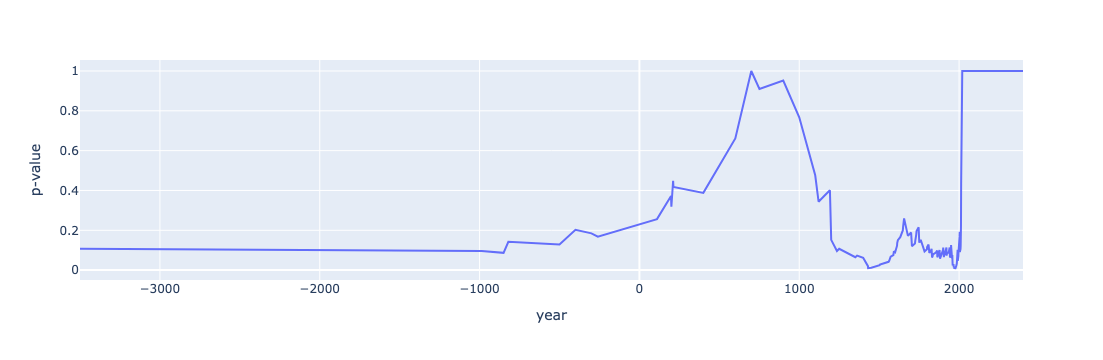

In [226]:

p_lst= []


for year in df['year_num'].dropna():
    p_lst.append(chisqp(year, 'year_num', 'camera'))
    p_df = pd.DataFrame(list(zip(df['year_num'].dropna(), p_lst)), columns = ['year', 'p-value'])
p_df


px.line(p_df.sort_values('year'), x = 'year', y = 'p-value')
    

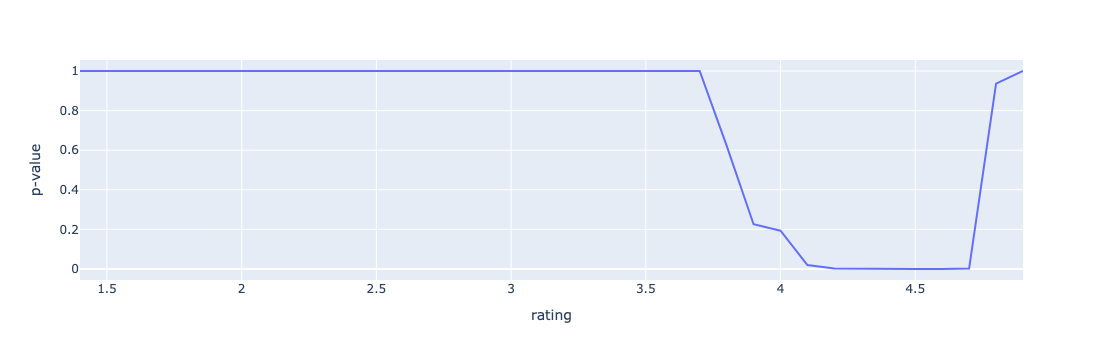

In [228]:

p_lst= []


for rating in df['rating'].dropna():
    p_lst.append(chisqp(rating, 'rating', 'camera'))
    p_df = pd.DataFrame(list(zip(df['rating'].dropna(), p_lst)), columns = ['rating', 'p-value'])
p_df


px.line(p_df.sort_values('rating'), x = 'rating', y = 'p-value')
    

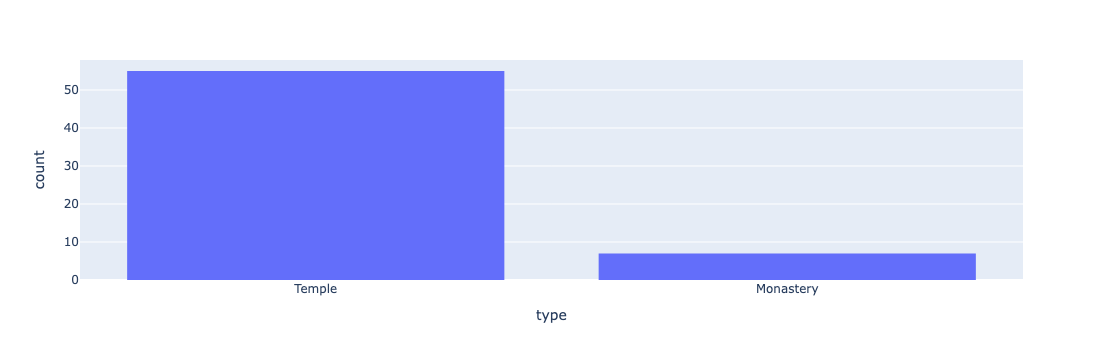

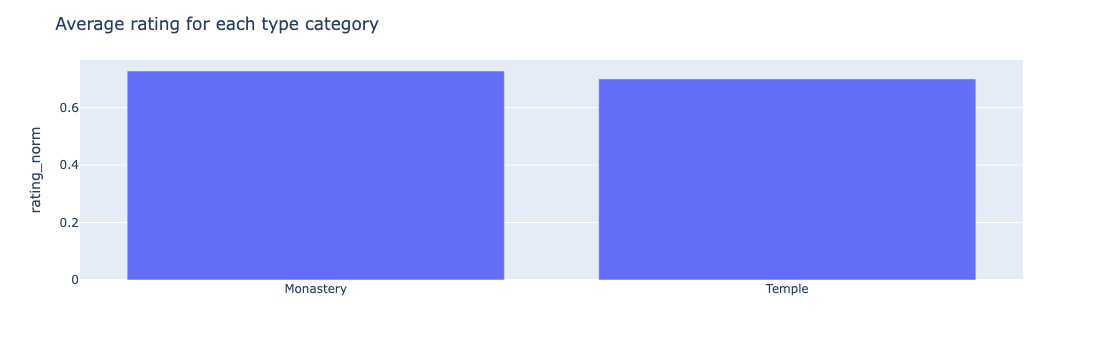

  Source  ddof1  ddof2         F     p-unc       np2
0   type     12     62  1.585068  0.119565  0.234765


In [2380]:
temp_df = df[df['significance'] == 'Religious']
categorical('type', 'rating_norm', df=temp_df)

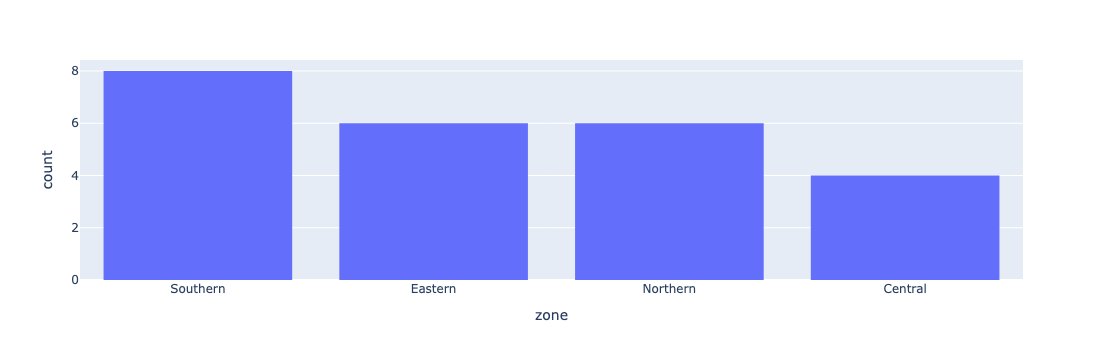

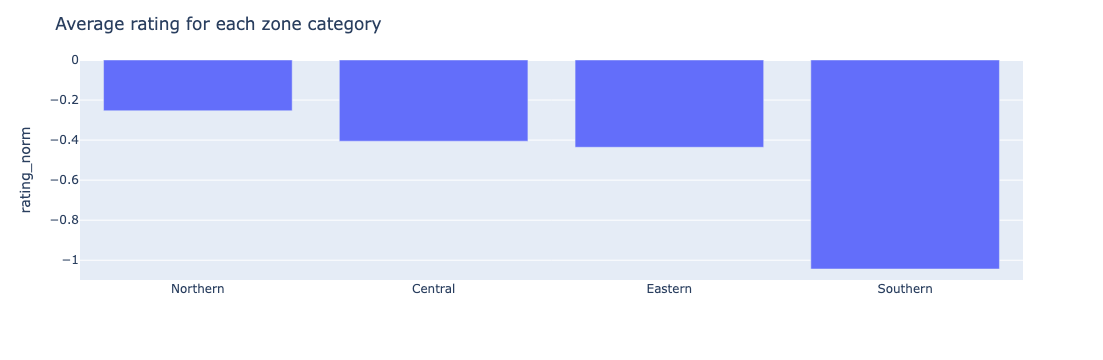

  Source  ddof1  ddof2         F     p-unc       np2
0   zone      5     23  2.070893  0.106068  0.310437


In [2422]:
temp_df = df[df['significance'] == 'Wildlife']
categorical('zone', 'rating_norm', df=temp_df)

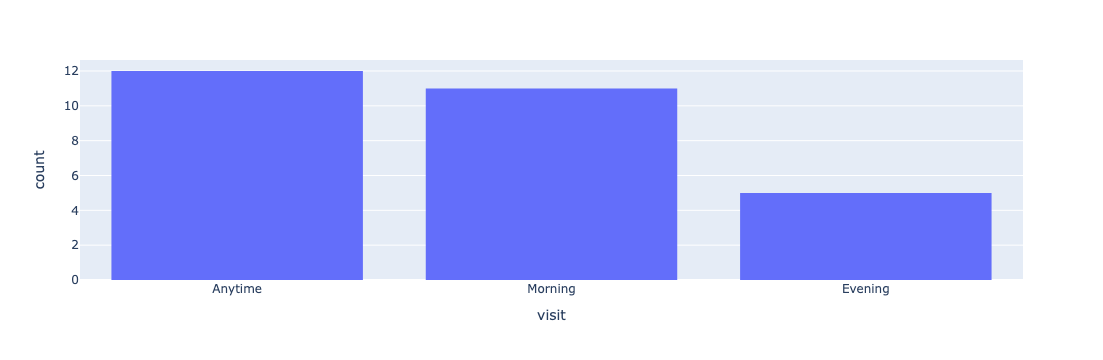

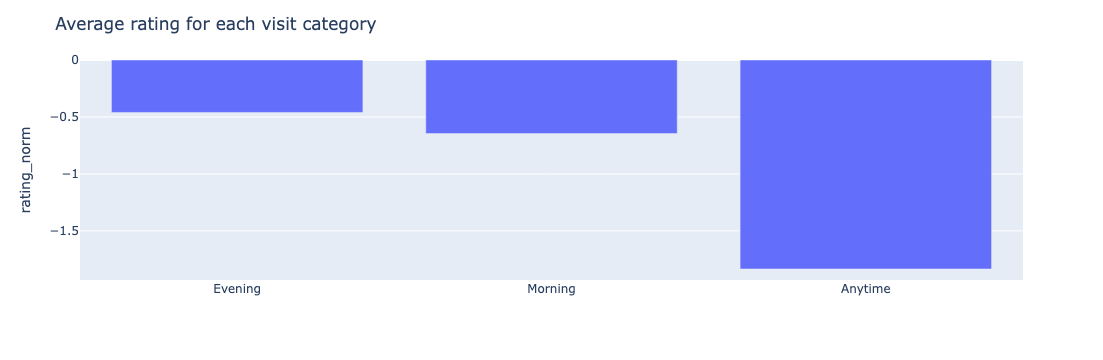

  Source  ddof1  ddof2         F    p-unc       np2
0  visit      3     26  0.786874  0.51214  0.083236


In [2378]:
temp_df = df[df['significance'] == 'Recreational']
categorical('visit', 'rating_norm', df=temp_df)